# 패키지 다운로드

In [ ]:
# pip install xarray

# 패키지 로딩

In [1]:
import xarray as xr

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

import tensorflow as tf

import warnings

warnings.filterwarnings("ignore")

# 종속변수(SCTR) 전처리

In [2]:
# nc -> csv 변환
ds = xr.open_dataset('./data/EN.4.2.2_D20_SCTR_f.nc')

df = ds.D20_SCTR.to_dataframe()

df.reset_index(inplace=True)

df.to_csv('./output/SCTR.csv', index=False)

ds.close()

# 종속변수 불러오기

In [40]:
sctr = pd.read_csv("./output/SCTR.csv")

# 날짜 형식 통일
sctr["TIME1"] = pd.to_datetime(sctr["TIME1"])
sctr["TIME1"] = sctr["TIME1"].dt.to_period('M').dt.to_timestamp()

# 날짜 컬럼 이름 변경
sctr = sctr.rename(columns={"TIME1":"Date"})

sctr

,Date,D20_SCTR
0,1991-01-01,54.960640
1,1991-02-01,59.899442
2,1991-03-01,70.225124
3,1991-04-01,67.375125
4,1991-05-01,63.783066
...,...,...
395,2023-12-01,124.376897
396,2024-01-01,117.300079
397,2024-02-01,121.968669
398,2024-03-01,118.355688


# 독립변수 전처리

## IOD
- WTIO  : 동경 50도 ~ 70도, 남위 10도 ~ 북위 10도에서 SST 편차의 평균 
- SETIO : 동경 90도 ~ 110도, 남위 10도 ~ 적도선에서 SST 편차의 평균
- DMI  = WTIO - SETIO

In [ ]:
# txt -> csv 변환
IOD = pd.read_csv("./data/IOD.txt", sep="\t", encoding="cp949")

# 날짜 형식 통일
IOD['Date'] = pd.to_datetime(IOD['Year'].astype(str) + '-' + IOD['Month'].astype(str) + '-01')
IOD = IOD.drop(["Year", "Month"], axis = 1)
IOD = IOD[["Date", "WTIO", "SETIO"]]

# DMI(Dipole Mode Index) 컬럼 생성
IOD["DMI"] = IOD["WTIO"] - IOD["SETIO"]

IOD.to_csv("./output/IOD.csv", encoding="utf-8-sig", index=False)

In [35]:
IOD = pd.read_csv("./output/IOD.csv")

IOD

,Date,WTIO,SETIO,DMI
0,1991-01-01,0.18,0.12,0.06
1,1991-02-01,0.05,-0.04,0.09
2,1991-03-01,-0.04,0.02,-0.06
3,1991-04-01,0.31,-0.45,0.76
4,1991-05-01,0.28,-0.62,0.90
...,...,...,...,...
395,2023-12-01,1.14,-0.07,1.21
396,2024-01-01,1.18,0.36,0.82
397,2024-02-01,1.22,0.92,0.30
398,2024-03-01,0.95,0.41,0.54


## ONI

In [32]:
# txt -> csv 변환
ONI = pd.read_csv("./data/ONI.txt", sep="\t", encoding="cp949")

# 날짜 형식 통일
ONI['Date'] = pd.to_datetime(ONI['Date'].astype(str) + '-01')

# ENSO 상태 결정 함수
def determine_enso(oni_values):
    if all(oni >= 0.5 for oni in oni_values):
        return 'El Nino'
    elif all(oni <= -0.5 for oni in oni_values):
        return 'La Nina'
    else:
        return 'Neutral'
    
ONI["ENSO"] = "Neutral"

for i in range(400):
    status = determine_enso(ONI.loc[i : i + 4, "ONI"])
    
    ONI["ENSO"].loc[i + 4] = status    

ONI = ONI[4:].reset_index(drop=True)

ONI.to_csv("./output/ONI.csv", encoding="utf-8-sig", index=False)

In [33]:
ONI = pd.read_csv("./output/ONI.csv")

ONI

,Date,ONI,ENSO
0,1991-01-01,0.41,Neutral
1,1991-02-01,0.26,Neutral
2,1991-03-01,0.22,Neutral
3,1991-04-01,0.26,Neutral
4,1991-05-01,0.45,Neutral
...,...,...,...
395,2023-12-01,1.95,El Nino
396,2024-01-01,1.79,El Nino
397,2024-02-01,1.49,El Nino
398,2024-03-01,1.14,El Nino


## SOI
- 남방진동지수, Darwin - Tahiti 사이의 표준화된 해면기압 차이

In [ ]:
# txt -> csv 변환
SOI = pd.read_csv("./data/SOI.txt", sep="\t", encoding="cp949")

# 날짜 형식 통일
SOI['Date'] = pd.to_datetime(SOI['Date'].astype(str) + '-01')

SOI.to_csv("./output/SOI.csv", encoding="utf-8-sig", index=False)

In [37]:
SOI = pd.read_csv("./output/SOI.csv")

SOI

,Date,SOI
0,1991-01-01,0.6
1,1991-02-01,0.3
2,1991-03-01,-0.7
3,1991-04-01,-0.6
4,1991-05-01,-1.0
...,...,...
395,2023-12-01,-0.2
396,2024-01-01,0.5
397,2024-02-01,-1.4
398,2024-03-01,0.4


## 독립변수 합치기

In [48]:
df = pd.merge(IOD, ONI, on="Date")
df = pd.merge(df, SOI, on="Date")

df.to_csv("./output/IND.csv", encoding="utf-8-sig", index=False)

# 독립변수 불러오기 & 종속변수 합치기

In [49]:
ind = pd.read_csv("./output/IND.csv")

ind["Date"] = pd.to_datetime(ind["Date"])

data = pd.merge(ind, sctr, on="Date").drop("Date", axis = 1)

data.to_csv("./output/data.csv", encoding="cp949", index=False)

In [2]:
data = pd.read_csv("./output/data.csv")

data

,WTIO,SETIO,DMI,ONI,ENSO,SOI,D20_SCTR
0,0.18,0.12,0.06,0.41,Neutral,0.6,54.960640
1,0.05,-0.04,0.09,0.26,Neutral,0.3,59.899442
2,-0.04,0.02,-0.06,0.22,Neutral,-0.7,70.225124
3,0.31,-0.45,0.76,0.26,Neutral,-0.6,67.375125
4,0.28,-0.62,0.90,0.45,Neutral,-1.0,63.783066
...,...,...,...,...,...,...,...
395,1.14,-0.07,1.21,1.95,El Nino,-0.2,124.376897
396,1.18,0.36,0.82,1.79,El Nino,0.5,117.300079
397,1.22,0.92,0.30,1.49,El Nino,-1.4,121.968669
398,0.95,0.41,0.54,1.14,El Nino,0.4,118.355688


# 함수 정의

In [3]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size

    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i + target_size])
            
    return np.array(data), np.array(labels)

In [4]:
def label_split(dataset, start_index, end_index, history_size, target_size, step):
    data = []

    start_index = start_index + history_size

    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        
    return np.array(data)

In [ ]:
def test_plot(dataset1, dataset2, history_size, target_size):
    data = []
    labels = []

    end_index = len(dataset1) - target_size

    for i in range(end_index):
        data.append(dataset1[i : i + history_size, :])
        labels.append(dataset2[i : i + history_size])
            
    return np.array(data), np.array(labels)

In [5]:
def plot_train_history(history, function):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))
    
    plt.figure(figsize=(12, 8))
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    
    plt.xlabel("Epoch")
    plt.ylabel(function)
    
    plt.title(f"{function} 손실함수 시각화")
    plt.legend()
    plt.grid()

    plt.show()

# 하이퍼 파라매터 세팅

In [6]:
# 전체 데이터 길이
total_length = len(data)

# 학습(0.7) - 검증(0.2) - 테스트(0.1) 데이터 분리
TRAIN_SPLIT = int(total_length * 0.7)
VAL_SPLIT = int(total_length * 0.2)
TEST_SPLIT = total_length - TRAIN_SPLIT - VAL_SPLIT

# 12개월 학습 - 12개월 예측
past_history = 12
future_target = 12
STEP = 1

BATCH_SIZE = 16
EPOCHS = 300

tf.random.set_seed(13)

# ENSO Label Encoding

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['ENSO'] = le.fit_transform(data['ENSO'])

# 인코딩 매핑 확인
encoding_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("인코딩 매핑:")
print(encoding_map)

인코딩 매핑:
{'El Nino': 0, 'La Nina': 1, 'Neutral': 2}


# Case1) WTIO, SETIO & 표준화

## 데이터 전처리

In [139]:
case1_df = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case1_dts = case1_df.values
print(case1_dts.shape)

case1_label = case1_dts[ : , 4]
case1_dts = case1_dts[ : , [0, 1, 2, 3, 5]]

case1_mean = case1_dts.mean(axis=0)
case1_std = case1_dts.std(axis=0)
case1_dts = (case1_dts-case1_mean)/case1_std

# case1_dts = np.column_stack((remain[:, :4], label, remain[:, 4:]))
print(case1_dts.shape)

(400, 6)
(400, 5)


In [140]:
# case1_df = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'D20_SCTR']]

# case1_dts = case1_df.values

# case1_mean = case1_dts.mean(axis=0)
# case1_std = case1_dts.std(axis=0)
# case1_dts = (case1_dts-case3_mean)/case1_std

## 데이터 분리

In [141]:
# # 학습 데이터
# x_train_multi, y_train_multi = multivariate_data(case1_dts, case1_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# # 검증 데이터
# x_val_multi, y_val_multi = multivariate_data(case1_dts, case1_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# # 테스트 데이터
# x_test_multi, y_test_multi = multivariate_data(case1_dts, case1_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

# print(f"학습 데이터 형태: {x_train_multi.shape}")
# print(f"검증 데이터 형태: {x_val_multi.shape}")
# print(f"테스트 데이터 형태: {x_test_multi.shape}")

# print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
# print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

In [142]:
# BUFFER_SIZE = 100

# train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))

# train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
# val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [143]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case1_dts, case1_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case1_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case1_dts, case1_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case1_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case1_dts, case1_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_label = label_split(case1_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"학습 타겟데이터 형태: {y_train_multi.shape}")
print(f"학습 라벨데이터 형태: {x_train_label.shape}")
print("--------------------------------")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"검증 타겟데이터 형태: {y_val_multi.shape}")
print(f"검증 라벨데이터 형태: {x_val_label.shape}")
print("--------------------------------")
print(f"테스트 데이터 형태: {x_test_multi.shape}")
print(f"테스트 타겟데이터 형태: {y_test_multi.shape}")
print(f"테스트 라벨데이터 형태: {x_test_label.shape}")
print("--------------------------------")
print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 5)
학습 타겟데이터 형태: (256, 12)
학습 라벨데이터 형태: (256, 12)
--------------------------------
검증 데이터 형태: (56, 12, 5)
검증 타겟데이터 형태: (56, 12)
검증 라벨데이터 형태: (56, 12)
--------------------------------
테스트 데이터 형태: (16, 12, 5)
테스트 타겟데이터 형태: (16, 12)
테스트 라벨데이터 형태: (16, 12)
--------------------------------
과거 데이터 윈도우 형태: (12, 5)
예측 목표 기간 형태: (12,)


## 모델 학습

### 단방향 LSTM

In [144]:
# from tensorflow.keras.optimizers import RMSprop, Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
# from tensorflow.keras.regularizers import l1_l2
    
# initial_lr = 0.0005

# optimizer = Adam(learning_rate=initial_lr)
# # optimizer = RMSprop(learning_rate=initial_lr, clipvalue=1.0)

# # 학습률 재시작
# lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# # EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# case1_lstm_uni = Sequential()

# case1_lstm_uni.add(LSTM(128, return_sequences=True,
#                           kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                           bias_regularizer=l1_l2(l1=0.005, l2=0.005),    
#                           input_shape=x_train_multi.shape[-2:]))
# case1_lstm_uni.add(BatchNormalization())
# case1_lstm_uni.add(Dropout(0.3))

# case1_lstm_uni.add(LSTM(64, return_sequences=True,
#                           kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                           bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
# case1_lstm_uni.add(BatchNormalization())
# case1_lstm_uni.add(Dropout(0.3))

# case1_lstm_uni.add(LSTM(32, activation='relu',
#                           kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                           bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
# case1_lstm_uni.add(BatchNormalization())
# case1_lstm_uni.add(Dropout(0.3))

# case1_lstm_uni.add(Dense(24, activation='relu'))
# case1_lstm_uni.add(Dense(12))

# case1_lstm_uni.compile(optimizer=optimizer, loss='mse')

# case1_lstm_uni_history = case1_lstm_uni.fit(
#     train_data_multi, 
#     epochs = EPOCHS, 
#     steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
#     validation_data = val_data_multi, 
#     validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
#     callbacks=[
#         lr_restart, 
#         early_stop
#     ])

# plot_train_history(case1_lstm_uni_history, "Case1, Sequential")

In [145]:
# Y_hat_case1_uni = case1_lstm_uni.predict(x_test_multi)

# Y_hat_case1_uni = Y_hat_case1_uni * case1_std[-1] + case1_mean[-1]

# case1_lstm_uni.save("./output/case1_lstm_uni.h5")

---

Epoch 1/300
16/16 [==============================] - 16s 134ms/step - loss: 23.1163 - root_mean_squared_error: 1.2951 - val_loss: 21.9958 - val_root_mean_squared_error: 0.9775 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 1s 42ms/step - loss: 22.0390 - root_mean_squared_error: 1.1722 - val_loss: 21.1909 - val_root_mean_squared_error: 0.9813 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 1s 41ms/step - loss: 21.0891 - root_mean_squared_error: 1.1224 - val_loss: 20.3430 - val_root_mean_squared_error: 0.9852 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 1s 41ms/step - loss: 20.0635 - root_mean_squared_error: 1.0490 - val_loss: 19.4746 - val_root_mean_squared_error: 0.9900 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 1s 43ms/step - loss: 19.1471 - root_mean_squared_error: 1.0352 - val_loss: 18.5894 - val_root_mean_squared_error: 0.9940 - lr: 5.0000e-04
Epoch 6/300
16/16 [========================

Epoch 44/300
16/16 [==============================] - 1s 42ms/step - loss: 2.9284 - root_mean_squared_error: 0.7623 - val_loss: 3.2790 - val_root_mean_squared_error: 0.9883 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 1s 41ms/step - loss: 2.8600 - root_mean_squared_error: 0.7703 - val_loss: 3.1895 - val_root_mean_squared_error: 0.9793 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 1s 42ms/step - loss: 2.7912 - root_mean_squared_error: 0.7688 - val_loss: 3.1593 - val_root_mean_squared_error: 0.9975 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 1s 42ms/step - loss: 2.7158 - root_mean_squared_error: 0.7634 - val_loss: 3.0644 - val_root_mean_squared_error: 0.9840 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 1s 43ms/step - loss: 2.6483 - root_mean_squared_error: 0.7641 - val_loss: 2.9860 - val_root_mean_squared_error: 0.9772 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 1s 43ms/step - loss: 1.3785 - root_mean_squared_error: 0.7229 - val_loss: 1.8202 - val_root_mean_squared_error: 0.9879 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 1s 40ms/step - loss: 1.3695 - root_mean_squared_error: 0.7311 - val_loss: 1.7890 - val_root_mean_squared_error: 0.9805 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 1s 42ms/step - loss: 1.3586 - root_mean_squared_error: 0.7331 - val_loss: 1.7229 - val_root_mean_squared_error: 0.9552 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 1s 40ms/step - loss: 1.3237 - root_mean_squared_error: 0.7218 - val_loss: 1.7501 - val_root_mean_squared_error: 0.9781 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 1s 42ms/step - loss: 1.3039 - root_mean_squared_error: 0.7208 - val_loss: 1.7065 - val_root_mean_squared_error: 0.9651 - lr: 5.0000e-04
Epoch 92/300
16/16 [==============================] - 1s 42ms/s

16/16 [==============================] - 1s 38ms/step - loss: 0.9096 - root_mean_squared_error: 0.6979 - val_loss: 1.4671 - val_root_mean_squared_error: 1.0234 - lr: 2.5000e-04
Epoch 130/300
16/16 [==============================] - 1s 43ms/step - loss: 0.9136 - root_mean_squared_error: 0.7049 - val_loss: 1.3482 - val_root_mean_squared_error: 0.9667 - lr: 2.5000e-04
Epoch 131/300
16/16 [==============================] - 1s 39ms/step - loss: 0.8998 - root_mean_squared_error: 0.6990 - val_loss: 1.3737 - val_root_mean_squared_error: 0.9826 - lr: 2.5000e-04
Epoch 132/300
16/16 [==============================] - 1s 41ms/step - loss: 0.8960 - root_mean_squared_error: 0.7002 - val_loss: 1.4614 - val_root_mean_squared_error: 1.0283 - lr: 2.5000e-04
Epoch 133/300
16/16 [==============================] - 1s 38ms/step - loss: 0.9019 - root_mean_squared_error: 0.7064 - val_loss: 1.4145 - val_root_mean_squared_error: 1.0071 - lr: 2.5000e-04
Epoch 134/300
16/16 [==============================] - 1s 3

16/16 [==============================] - 1s 39ms/step - loss: 0.7367 - root_mean_squared_error: 0.6754 - val_loss: 1.2825 - val_root_mean_squared_error: 1.0011 - lr: 1.5625e-05
Epoch 169/300
16/16 [==============================] - 1s 43ms/step - loss: 0.7250 - root_mean_squared_error: 0.6670 - val_loss: 1.2827 - val_root_mean_squared_error: 1.0014 - lr: 1.5625e-05
Epoch 170/300
15/16 [===========================>..] - ETA: 0s - loss: 0.7340 - root_mean_squared_error: 0.6741
Epoch 170: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
16/16 [==============================] - 1s 42ms/step - loss: 0.7343 - root_mean_squared_error: 0.6743 - val_loss: 1.2803 - val_root_mean_squared_error: 1.0005 - lr: 1.5625e-05


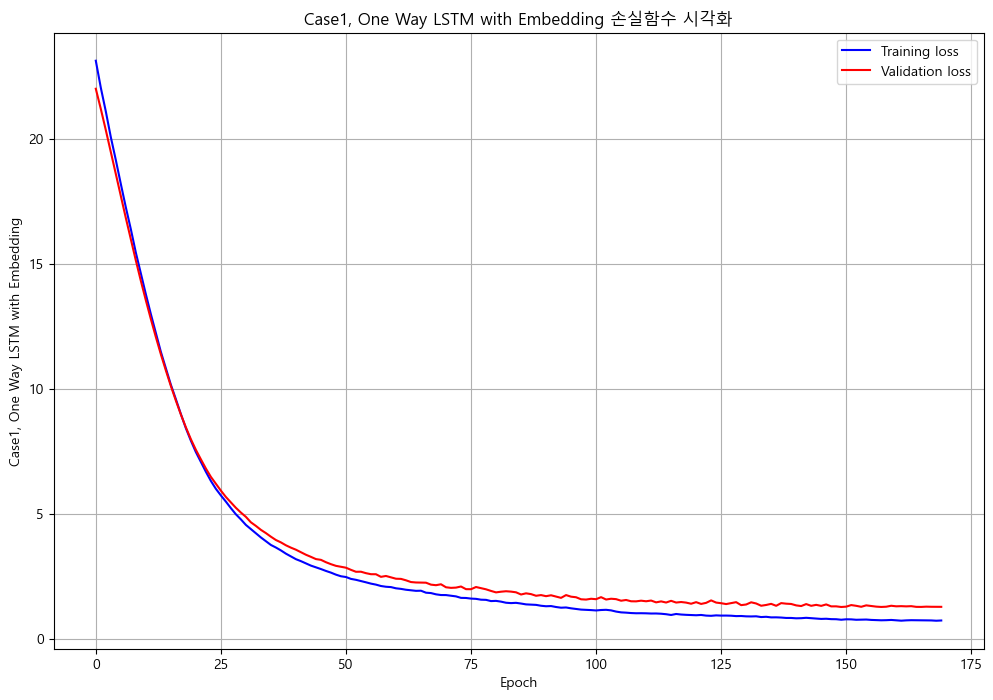

In [146]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case1_uni_label = Model(inputs=[numerical_input, categorical_input], outputs=output)
case1_uni_label.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case1_uni_label_history = case1_uni_label.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case1_uni_label_history, "Case1, One Way LSTM with Embedding")

In [147]:
# case1_uni_label.save("./output/case1_lstm_uni_label_mae.h5")
# case1_uni_label.save("./output/case1_lstm_uni_label_mse.h5")
case1_uni_label.save("./output/case1_lstm_uni_label_mse+rmse.h5")

### 양방향 LSTM

In [148]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Attention, Concatenate
# from tensorflow.keras.regularizers import l1_l2

# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.optimizers import legacy as legacy_optimizers

# # Attention 레이어 정의
# def attention_layer(inputs):
#     attention = Attention()([inputs, inputs])
#     return Concatenate()([inputs, attention])

# # 옵티마이저 설정
# initial_lr = 0.0005
# optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# # 학습률 재시작
# lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# # EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # 모델 정의
# inputs = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))

# x = Bidirectional(LSTM(128, return_sequences=True,
#                        kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                        bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(inputs)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# x = Bidirectional(LSTM(64, return_sequences=True,
#                        kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                        bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# x = attention_layer(x)

# x = LSTM(32, activation='relu',
#          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#          bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# x = Dense(24, activation='relu',
#           kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#           bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
# outputs = Dense(12)(x)

# case1_lstm_bi = Model(inputs=inputs, outputs=outputs)

# # 모델 빌드 및 컴파일
# case1_lstm_bi.build(input_shape=(None, x_train_multi.shape[1], x_train_multi.shape[2]))
# case1_lstm_bi.compile(optimizer=optimizer, loss='mse')

# # 모델 학습
# case1_lstm_bi_history = case1_lstm_bi.fit(
#     train_data_multi,
#     epochs=EPOCHS,
#     steps_per_epoch=x_train_multi.shape[0] // BATCH_SIZE,
#     validation_data=val_data_multi,
#     validation_steps=x_val_multi.shape[0] // BATCH_SIZE,
#     callbacks=[lr_restart, early_stop]
# )

# plot_train_history(case1_lstm_bi_history, "Case1, Bidirectional")

In [149]:
# Y_hat_case1_bi = case1_lstm_bi.predict(x_test_multi)

# Y_hat_case1_bi = Y_hat_case1_bi * case1_std[-1] + case1_mean[-1]

# case1_lstm_bi.save("./output/case1_lstm_bi.h5")

---

Epoch 1/300
16/16 [==============================] - 12s 207ms/step - loss: 56.0127 - root_mean_squared_error: 1.2239 - val_loss: 53.5789 - val_root_mean_squared_error: 0.9803 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 1s 79ms/step - loss: 52.1526 - root_mean_squared_error: 1.1234 - val_loss: 49.9203 - val_root_mean_squared_error: 0.9941 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 1s 78ms/step - loss: 48.3793 - root_mean_squared_error: 1.0767 - val_loss: 46.2988 - val_root_mean_squared_error: 1.0055 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 1s 68ms/step - loss: 44.6977 - root_mean_squared_error: 1.0459 - val_loss: 42.7437 - val_root_mean_squared_error: 1.0195 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 1s 79ms/step - loss: 41.0439 - root_mean_squared_error: 0.9936 - val_loss: 39.2629 - val_root_mean_squared_error: 1.0247 - lr: 5.0000e-04
Epoch 6/300
16/16 [========================

Epoch 44/300
16/16 [==============================] - 1s 70ms/step - loss: 3.6964 - root_mean_squared_error: 0.7848 - val_loss: 3.9811 - val_root_mean_squared_error: 0.9728 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 1s 70ms/step - loss: 3.6005 - root_mean_squared_error: 0.7794 - val_loss: 3.8884 - val_root_mean_squared_error: 0.9703 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 1s 69ms/step - loss: 3.5000 - root_mean_squared_error: 0.7683 - val_loss: 3.8129 - val_root_mean_squared_error: 0.9709 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 1s 71ms/step - loss: 3.4020 - root_mean_squared_error: 0.7557 - val_loss: 3.7226 - val_root_mean_squared_error: 0.9625 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 1s 68ms/step - loss: 3.3759 - root_mean_squared_error: 0.7782 - val_loss: 3.6842 - val_root_mean_squared_error: 0.9631 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 1s 69ms/step - loss: 1.8424 - root_mean_squared_error: 0.7272 - val_loss: 2.2477 - val_root_mean_squared_error: 0.9739 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 1s 67ms/step - loss: 1.8278 - root_mean_squared_error: 0.7332 - val_loss: 2.4092 - val_root_mean_squared_error: 1.0598 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 1s 68ms/step - loss: 1.8268 - root_mean_squared_error: 0.7443 - val_loss: 2.2723 - val_root_mean_squared_error: 1.0091 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 1s 71ms/step - loss: 1.7499 - root_mean_squared_error: 0.7132 - val_loss: 2.2182 - val_root_mean_squared_error: 0.9963 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 1s 66ms/step - loss: 1.7242 - root_mean_squared_error: 0.7155 - val_loss: 2.1417 - val_root_mean_squared_error: 0.9709 - lr: 5.0000e-04
Epoch 92/300
16/16 [==============================] - 1s 71ms/s

16/16 [==============================] - 1s 70ms/step - loss: 0.9663 - root_mean_squared_error: 0.7021 - val_loss: 1.3592 - val_root_mean_squared_error: 0.9455 - lr: 5.0000e-04
Epoch 131/300
16/16 [==============================] - 1s 71ms/step - loss: 0.9419 - root_mean_squared_error: 0.6964 - val_loss: 1.4106 - val_root_mean_squared_error: 0.9811 - lr: 5.0000e-04
Epoch 132/300
16/16 [==============================] - 1s 72ms/step - loss: 0.9392 - root_mean_squared_error: 0.7057 - val_loss: 1.4929 - val_root_mean_squared_error: 1.0287 - lr: 5.0000e-04
Epoch 133/300
16/16 [==============================] - 1s 72ms/step - loss: 0.9328 - root_mean_squared_error: 0.7091 - val_loss: 1.4956 - val_root_mean_squared_error: 1.0346 - lr: 5.0000e-04
Epoch 134/300
16/16 [==============================] - 1s 70ms/step - loss: 0.8915 - root_mean_squared_error: 0.6887 - val_loss: 1.3504 - val_root_mean_squared_error: 0.9708 - lr: 5.0000e-04
Epoch 135/300
16/16 [==============================] - 1s 7

16/16 [==============================] - 1s 71ms/step - loss: 0.5428 - root_mean_squared_error: 0.6801 - val_loss: 1.0489 - val_root_mean_squared_error: 0.9846 - lr: 6.2500e-05
Epoch 171/300
16/16 [==============================] - 1s 69ms/step - loss: 0.5515 - root_mean_squared_error: 0.6873 - val_loss: 1.0703 - val_root_mean_squared_error: 0.9956 - lr: 6.2500e-05
Epoch 172/300
16/16 [==============================] - 1s 69ms/step - loss: 0.5383 - root_mean_squared_error: 0.6779 - val_loss: 1.0618 - val_root_mean_squared_error: 0.9917 - lr: 6.2500e-05
Epoch 173/300
16/16 [==============================] - ETA: 0s - loss: 0.5288 - root_mean_squared_error: 0.6716
Epoch 173: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
16/16 [==============================] - 1s 70ms/step - loss: 0.5288 - root_mean_squared_error: 0.6716 - val_loss: 1.0630 - val_root_mean_squared_error: 0.9927 - lr: 6.2500e-05
Epoch 174/300
16/16 [==============================] - 1s 69ms/step - loss

16/16 [==============================] - 1s 66ms/step - loss: 0.5245 - root_mean_squared_error: 0.6762 - val_loss: 1.0472 - val_root_mean_squared_error: 0.9899 - lr: 1.0000e-06
Epoch 208/300
16/16 [==============================] - 1s 72ms/step - loss: 0.5205 - root_mean_squared_error: 0.6733 - val_loss: 1.0468 - val_root_mean_squared_error: 0.9897 - lr: 1.0000e-06
Epoch 209/300
16/16 [==============================] - 1s 70ms/step - loss: 0.5151 - root_mean_squared_error: 0.6693 - val_loss: 1.0467 - val_root_mean_squared_error: 0.9897 - lr: 1.0000e-06
Epoch 210/300
16/16 [==============================] - 1s 69ms/step - loss: 0.5252 - root_mean_squared_error: 0.6768 - val_loss: 1.0464 - val_root_mean_squared_error: 0.9896 - lr: 1.0000e-06
Epoch 211/300
16/16 [==============================] - 1s 70ms/step - loss: 0.4994 - root_mean_squared_error: 0.6575 - val_loss: 1.0465 - val_root_mean_squared_error: 0.9896 - lr: 1.0000e-06
Epoch 212/300
16/16 [==============================] - 1s 7

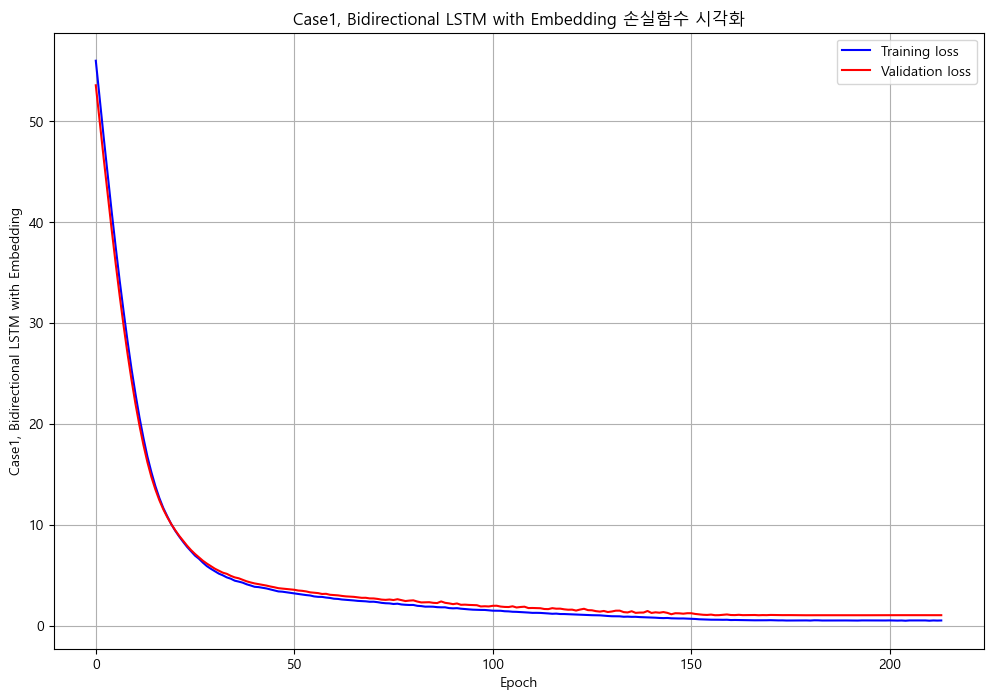

In [150]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case1_bi_label = Model(inputs=[numerical_input, categorical_input], outputs=output)
case1_bi_label.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case1_bi_label_history = case1_bi_label.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case1_bi_label_history, "Case1, Bidirectional LSTM with Embedding")

In [151]:
# case1_bi_label.save("./output/case1_lstm_bi_label_mae.h5")
# case1_bi_label.save("./output/case1_lstm_bi_label_mse.h5")
case1_bi_label.save("./output/case1_lstm_bi_label_mse+rmse.h5")

# Case2) WTIO, SETIO & 로그변환

## 데이터 전처리

### 부호 유지 로그 변환

In [152]:
case2_df = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case2_dts = case2_df.values
print(case2_dts.shape)

case2_label = case2_dts[ : , 4]
case2_dts = case2_dts[ : , [0, 1, 2, 3, 5]]

case2_dts = np.sign(case2_dts) * np.log1p(np.abs(case2_dts))
print(case2_dts.shape)

(400, 6)
(400, 5)


In [153]:
# # case2_df = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'D20_SCTR']]
# case2_dts = case2_df.values

# case2_dts = np.sign(case2_dts) * np.log1p(np.abs(case2_dts))

### 데이터 분포 확인

In [154]:
# fig, ax = plt.subplots(5, 2, figsize=(8, 16))

# i = 0

# colors = ["red", "blue", "green", "yellow", "orange"]

# for column in case2_df.columns:

#     ax[i][0].hist(case2_df[column], bins=30, label=column, color=colors[i])
#     ax[i][0].grid(axis = "y")
    
#     ax[i][1].hist(case2_dts[:, i], bins=30, label=column, color=colors[i])
#     ax[i][1].grid(axis = "y")

#     i += 1
    
# for j, col_title in enumerate(['원본', '로그 변환']):
#     fig.text(0.29 + j * 0.45, 0.89, col_title, ha='center', va='center', fontsize=16, fontweight='bold')
    
# for i, label in enumerate(['WTIO', 'SETIO', 'ONI', 'SOI', 'D20_SCTR']):
#     fig.text(0.08, 0.8 - i * 0.153, label, va='center', ha='right', fontsize=16, rotation=90, fontweight='bold')

## 데이터 분리

In [155]:
# # 학습 데이터
# x_train_multi, y_train_multi = multivariate_data(case2_dts, case2_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# # 검증 데이터
# x_val_multi, y_val_multi = multivariate_data(case2_dts, case2_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# # 테스트 데이터
# x_test_multi, y_test_multi = multivariate_data(case2_dts, case2_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

# print(f"학습 데이터 형태: {x_train_multi.shape}")
# print(f"검증 데이터 형태: {x_val_multi.shape}")
# print(f"테스트 데이터 형태: {x_test_multi.shape}")

# print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
# print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

In [156]:
# BUFFER_SIZE = 100

# train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))

# train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
# val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [157]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case2_dts, case2_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case2_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case2_dts, case2_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case2_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case2_dts, case2_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_label = label_split(case2_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"학습 타겟데이터 형태: {y_train_multi.shape}")
print(f"학습 라벨데이터 형태: {x_train_label.shape}")
print("--------------------------------")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"검증 타겟데이터 형태: {y_val_multi.shape}")
print(f"검증 라벨데이터 형태: {x_val_label.shape}")
print("--------------------------------")
print(f"테스트 데이터 형태: {x_test_multi.shape}")
print(f"테스트 타겟데이터 형태: {y_test_multi.shape}")
print(f"테스트 라벨데이터 형태: {x_test_label.shape}")
print("--------------------------------")
print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 5)
학습 타겟데이터 형태: (256, 12)
학습 라벨데이터 형태: (256, 12)
--------------------------------
검증 데이터 형태: (56, 12, 5)
검증 타겟데이터 형태: (56, 12)
검증 라벨데이터 형태: (56, 12)
--------------------------------
테스트 데이터 형태: (16, 12, 5)
테스트 타겟데이터 형태: (16, 12)
테스트 라벨데이터 형태: (16, 12)
--------------------------------
과거 데이터 윈도우 형태: (12, 5)
예측 목표 기간 형태: (12,)


## 모델 학습

### 단방향 LSTM

In [158]:
# from tensorflow.keras.optimizers import RMSprop, Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
# from tensorflow.keras.regularizers import l1_l2
    
# initial_lr = 0.0005

# optimizer = Adam(learning_rate=initial_lr)
# # optimizer = RMSprop(learning_rate=initial_lr, clipvalue=1.0)

# # 학습률 재시작
# lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# # EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# case2_lstm_uni = Sequential()

# case2_lstm_uni.add(LSTM(128, return_sequences=True,
#                           kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                           bias_regularizer=l1_l2(l1=0.005, l2=0.005),    
#                           input_shape=x_train_multi.shape[-2:]))
# case2_lstm_uni.add(BatchNormalization())
# case2_lstm_uni.add(Dropout(0.3))

# case2_lstm_uni.add(LSTM(64, return_sequences=True,
#                           kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                           bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
# case2_lstm_uni.add(BatchNormalization())
# case2_lstm_uni.add(Dropout(0.3))

# case2_lstm_uni.add(LSTM(32, activation='relu',
#                           kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                           bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
# case2_lstm_uni.add(BatchNormalization())
# case2_lstm_uni.add(Dropout(0.3))

# case2_lstm_uni.add(Dense(24, activation='relu'))
# case2_lstm_uni.add(Dense(12))

# case2_lstm_uni.compile(optimizer=optimizer, loss='mse')

# case2_lstm_uni_history = case2_lstm_uni.fit(
#     train_data_multi, 
#     epochs = EPOCHS, 
#     steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
#     validation_data = val_data_multi, 
#     validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
#     callbacks=[
#         lr_restart, 
#         early_stop
#     ])

# plot_train_history(case2_lstm_uni_history, "Case2, Sequential")

In [159]:
# Y_hat_case2_uni = case2_lstm_uni.predict(x_test_multi)

# Y_hat_case2_uni = np.sign(Y_hat_case2_uni) * (np.expm1(np.abs(Y_hat_case2_uni)))

# case2_lstm_uni.save("./output/case2_lstm_uni.h5")

----

Epoch 1/300
16/16 [==============================] - 9s 136ms/step - loss: 40.7299 - root_mean_squared_error: 4.3730 - val_loss: 40.3496 - val_root_mean_squared_error: 4.3567 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 1s 39ms/step - loss: 38.3234 - root_mean_squared_error: 4.1440 - val_loss: 39.4655 - val_root_mean_squared_error: 4.3091 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 1s 36ms/step - loss: 36.2234 - root_mean_squared_error: 3.9449 - val_loss: 38.2523 - val_root_mean_squared_error: 4.2265 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 1s 38ms/step - loss: 33.9471 - root_mean_squared_error: 3.7156 - val_loss: 36.8098 - val_root_mean_squared_error: 4.1171 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 1s 39ms/step - loss: 31.6040 - root_mean_squared_error: 3.4638 - val_loss: 35.1914 - val_root_mean_squared_error: 3.9841 - lr: 5.0000e-04
Epoch 6/300
16/16 [=========================

Epoch 44/300
16/16 [==============================] - 1s 37ms/step - loss: 6.0388 - root_mean_squared_error: 0.8922 - val_loss: 5.3755 - val_root_mean_squared_error: 0.4689 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 1s 35ms/step - loss: 5.8137 - root_mean_squared_error: 0.8560 - val_loss: 5.1689 - val_root_mean_squared_error: 0.4057 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 1s 36ms/step - loss: 5.8080 - root_mean_squared_error: 0.9298 - val_loss: 5.2134 - val_root_mean_squared_error: 0.5561 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 1s 39ms/step - loss: 5.5929 - root_mean_squared_error: 0.8578 - val_loss: 5.1531 - val_root_mean_squared_error: 0.6039 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 1s 42ms/step - loss: 5.4666 - root_mean_squared_error: 0.8710 - val_loss: 4.9738 - val_root_mean_squared_error: 0.5904 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 1s 37ms/step - loss: 2.3992 - root_mean_squared_error: 0.6886 - val_loss: 2.3412 - val_root_mean_squared_error: 0.6641 - lr: 5.0000e-04
Epoch 88/300
15/16 [===========================>..] - ETA: 0s - loss: 2.3871 - root_mean_squared_error: 0.7108
Epoch 88: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 [==============================] - 1s 35ms/step - loss: 2.3859 - root_mean_squared_error: 0.7106 - val_loss: 2.4048 - val_root_mean_squared_error: 0.7370 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 1s 35ms/step - loss: 2.3558 - root_mean_squared_error: 0.7143 - val_loss: 2.3039 - val_root_mean_squared_error: 0.6867 - lr: 2.5000e-04
Epoch 90/300
16/16 [==============================] - 1s 36ms/step - loss: 2.3316 - root_mean_squared_error: 0.7157 - val_loss: 2.2022 - val_root_mean_squared_error: 0.6298 - lr: 2.5000e-04
Epoch 91/300
16/16 [==============================] - 1s 35ms/step - loss: 2.3

16/16 [==============================] - 1s 40ms/step - loss: 1.7010 - root_mean_squared_error: 0.6374 - val_loss: 1.4359 - val_root_mean_squared_error: 0.3825 - lr: 1.2500e-04
Epoch 129/300
16/16 [==============================] - 1s 40ms/step - loss: 1.7184 - root_mean_squared_error: 0.6561 - val_loss: 1.3908 - val_root_mean_squared_error: 0.3205 - lr: 1.2500e-04
Epoch 130/300
16/16 [==============================] - 1s 40ms/step - loss: 1.7348 - root_mean_squared_error: 0.6712 - val_loss: 1.4058 - val_root_mean_squared_error: 0.3541 - lr: 1.2500e-04
Epoch 131/300
16/16 [==============================] - 1s 39ms/step - loss: 1.6908 - root_mean_squared_error: 0.6432 - val_loss: 1.3817 - val_root_mean_squared_error: 0.3282 - lr: 1.2500e-04
Epoch 132/300
16/16 [==============================] - 1s 39ms/step - loss: 1.7384 - root_mean_squared_error: 0.6840 - val_loss: 1.3723 - val_root_mean_squared_error: 0.3209 - lr: 1.2500e-04
Epoch 133/300
16/16 [==============================] - 1s 4

Epoch 171/300
16/16 [==============================] - 1s 42ms/step - loss: 1.4474 - root_mean_squared_error: 0.6374 - val_loss: 1.1613 - val_root_mean_squared_error: 0.3527 - lr: 1.2500e-04
Epoch 172/300
16/16 [==============================] - 1s 42ms/step - loss: 1.4697 - root_mean_squared_error: 0.6583 - val_loss: 1.1404 - val_root_mean_squared_error: 0.3199 - lr: 1.2500e-04
Epoch 173/300
16/16 [==============================] - 1s 40ms/step - loss: 1.4896 - root_mean_squared_error: 0.6713 - val_loss: 1.1748 - val_root_mean_squared_error: 0.3718 - lr: 1.2500e-04
Epoch 174/300
16/16 [==============================] - 1s 37ms/step - loss: 1.4212 - root_mean_squared_error: 0.6214 - val_loss: 1.0871 - val_root_mean_squared_error: 0.2289 - lr: 1.2500e-04
Epoch 175/300
16/16 [==============================] - 1s 35ms/step - loss: 1.4572 - root_mean_squared_error: 0.6537 - val_loss: 1.0997 - val_root_mean_squared_error: 0.2717 - lr: 1.2500e-04
Epoch 176/300
16/16 [========================

Epoch 214/300
16/16 [==============================] - 1s 34ms/step - loss: 1.2010 - root_mean_squared_error: 0.6026 - val_loss: 0.9052 - val_root_mean_squared_error: 0.2682 - lr: 1.2500e-04
Epoch 215/300
16/16 [==============================] - 1s 36ms/step - loss: 1.2202 - root_mean_squared_error: 0.6237 - val_loss: 0.9171 - val_root_mean_squared_error: 0.2990 - lr: 1.2500e-04
Epoch 216/300
16/16 [==============================] - 1s 38ms/step - loss: 1.1810 - root_mean_squared_error: 0.5970 - val_loss: 0.8955 - val_root_mean_squared_error: 0.2735 - lr: 1.2500e-04
Epoch 217/300
16/16 [==============================] - 1s 35ms/step - loss: 1.2014 - root_mean_squared_error: 0.6184 - val_loss: 0.9024 - val_root_mean_squared_error: 0.2921 - lr: 1.2500e-04
Epoch 218/300
16/16 [==============================] - 1s 36ms/step - loss: 1.2017 - root_mean_squared_error: 0.6231 - val_loss: 0.8996 - val_root_mean_squared_error: 0.2953 - lr: 1.2500e-04
Epoch 219/300
16/16 [========================

Epoch 256/300
16/16 [==============================] - 1s 38ms/step - loss: 1.0292 - root_mean_squared_error: 0.5896 - val_loss: 0.7759 - val_root_mean_squared_error: 0.3119 - lr: 6.2500e-05
Epoch 257/300
16/16 [==============================] - 1s 37ms/step - loss: 0.9808 - root_mean_squared_error: 0.5503 - val_loss: 0.7669 - val_root_mean_squared_error: 0.2998 - lr: 6.2500e-05
Epoch 258/300
15/16 [===========================>..] - ETA: 0s - loss: 1.0504 - root_mean_squared_error: 0.6118
Epoch 258: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
16/16 [==============================] - 1s 35ms/step - loss: 1.0421 - root_mean_squared_error: 0.6051 - val_loss: 0.7868 - val_root_mean_squared_error: 0.3352 - lr: 6.2500e-05
Epoch 259/300
16/16 [==============================] - 1s 34ms/step - loss: 1.0494 - root_mean_squared_error: 0.6136 - val_loss: 0.7908 - val_root_mean_squared_error: 0.3450 - lr: 3.1250e-05
Epoch 260/300
16/16 [==============================] - 1s 35

16/16 [==============================] - 1s 34ms/step - loss: 0.9733 - root_mean_squared_error: 0.5810 - val_loss: 0.7168 - val_root_mean_squared_error: 0.2852 - lr: 3.9063e-06
Epoch 296/300
16/16 [==============================] - 1s 34ms/step - loss: 0.9128 - root_mean_squared_error: 0.5268 - val_loss: 0.7148 - val_root_mean_squared_error: 0.2824 - lr: 3.9063e-06
Epoch 297/300
16/16 [==============================] - 1s 35ms/step - loss: 0.9433 - root_mean_squared_error: 0.5552 - val_loss: 0.7106 - val_root_mean_squared_error: 0.2750 - lr: 3.9063e-06
Epoch 298/300
16/16 [==============================] - 1s 36ms/step - loss: 0.9907 - root_mean_squared_error: 0.5965 - val_loss: 0.7120 - val_root_mean_squared_error: 0.2780 - lr: 3.9063e-06
Epoch 299/300
15/16 [===========================>..] - ETA: 0s - loss: 0.9569 - root_mean_squared_error: 0.5678
Epoch 299: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
16/16 [==============================] - 1s 37ms/step - los

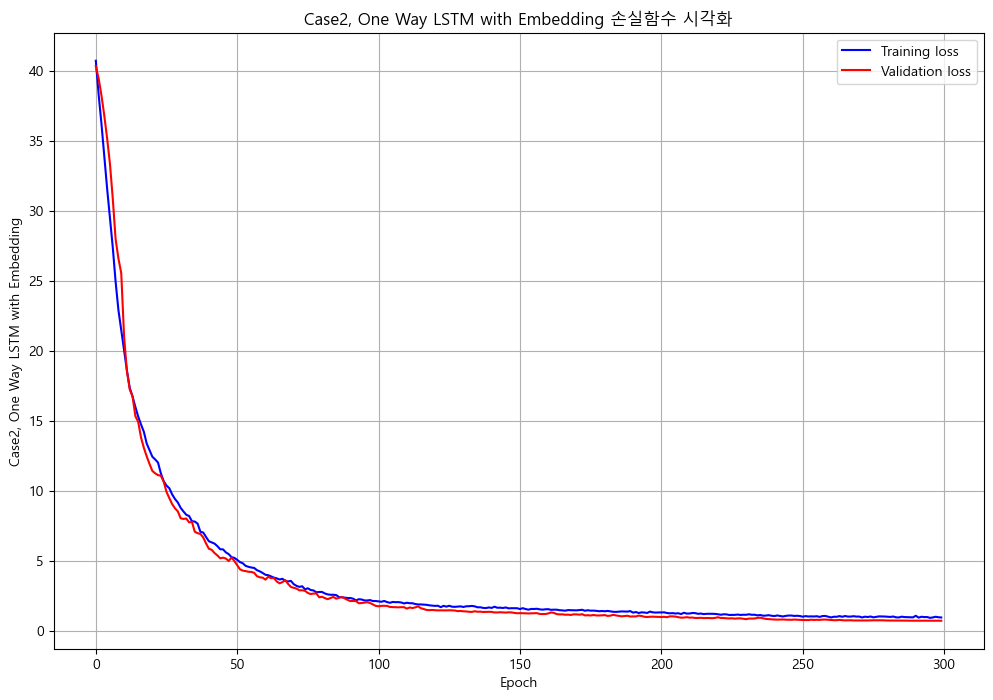

In [160]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case2_uni_label = Model(inputs=[numerical_input, categorical_input], outputs=output)
case2_uni_label.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case2_uni_label_history = case2_uni_label.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case2_uni_label_history, "Case2, One Way LSTM with Embedding")

In [161]:
# case2_uni_label.save("./output/case2_lstm_uni_label_mae.h5")
# case2_uni_label.save("./output/case2_lstm_uni_label_mse.h5")
case2_uni_label.save("./output/case2_lstm_uni_label_mse+rmse.h5")

### 양방향 LSTM

In [162]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Attention, Concatenate
# from tensorflow.keras.regularizers import l1_l2

# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.optimizers import legacy as legacy_optimizers

# # Attention 레이어 정의
# def attention_layer(inputs):
#     attention = Attention()([inputs, inputs])
#     return Concatenate()([inputs, attention])

# # 옵티마이저 설정
# initial_lr = 0.0005
# optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# # 학습률 재시작
# lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# # EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # 모델 정의
# inputs = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))

# x = Bidirectional(LSTM(128, return_sequences=True,
#                        kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                        bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(inputs)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# x = Bidirectional(LSTM(64, return_sequences=True,
#                        kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                        bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# x = attention_layer(x)

# x = LSTM(32, activation='relu',
#          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#          bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# x = Dense(24, activation='relu',
#           kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#           bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
# outputs = Dense(12)(x)

# case2_lstm_bi = Model(inputs=inputs, outputs=outputs)

# # 모델 빌드 및 컴파일
# case2_lstm_bi.build(input_shape=(None, x_train_multi.shape[1], x_train_multi.shape[2]))
# case2_lstm_bi.compile(optimizer=optimizer, loss='mse')

# # 모델 학습
# case2_lstm_bi_history = case2_lstm_bi.fit(
#     train_data_multi,
#     epochs=EPOCHS,
#     steps_per_epoch=x_train_multi.shape[0] // BATCH_SIZE,
#     validation_data=val_data_multi,
#     validation_steps=x_val_multi.shape[0] // BATCH_SIZE,
#     callbacks=[lr_restart, early_stop]
# )

# plot_train_history(case2_lstm_bi_history, "Case2, Bidirectional")

In [163]:
# Y_hat_case2_bi = case2_lstm_bi.predict(x_test_multi)

# Y_hat_case2_bi = np.sign(Y_hat_case2_bi) * (np.expm1(np.abs(Y_hat_case2_bi)))

# case2_lstm_bi.save("./output/case2_lstm_bi.h5")

----

Epoch 1/300
16/16 [==============================] - 13s 221ms/step - loss: 75.1481 - root_mean_squared_error: 4.4452 - val_loss: 73.4305 - val_root_mean_squared_error: 4.3609 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 1s 60ms/step - loss: 71.3504 - root_mean_squared_error: 4.2244 - val_loss: 71.2932 - val_root_mean_squared_error: 4.3420 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 1s 59ms/step - loss: 67.7114 - root_mean_squared_error: 4.0311 - val_loss: 68.9402 - val_root_mean_squared_error: 4.3130 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 1s 63ms/step - loss: 63.9160 - root_mean_squared_error: 3.8196 - val_loss: 66.3722 - val_root_mean_squared_error: 4.2663 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 1s 60ms/step - loss: 60.2211 - root_mean_squared_error: 3.6170 - val_loss: 63.5738 - val_root_mean_squared_error: 4.1963 - lr: 5.0000e-04
Epoch 6/300
16/16 [========================

Epoch 44/300
16/16 [==============================] - 1s 61ms/step - loss: 6.9383 - root_mean_squared_error: 0.8830 - val_loss: 7.2208 - val_root_mean_squared_error: 1.0812 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 1s 60ms/step - loss: 6.6681 - root_mean_squared_error: 0.8539 - val_loss: 7.1774 - val_root_mean_squared_error: 1.1696 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 1s 59ms/step - loss: 6.3218 - root_mean_squared_error: 0.7892 - val_loss: 6.6497 - val_root_mean_squared_error: 1.0401 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 1s 60ms/step - loss: 6.1681 - root_mean_squared_error: 0.8401 - val_loss: 6.6128 - val_root_mean_squared_error: 1.1225 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 1s 58ms/step - loss: 5.9303 - root_mean_squared_error: 0.8127 - val_loss: 6.7699 - val_root_mean_squared_error: 1.2679 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - ETA: 0s - loss: 3.1009 - root_mean_squared_error: 0.7581
Epoch 86: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
16/16 [==============================] - 1s 58ms/step - loss: 3.1009 - root_mean_squared_error: 0.7581 - val_loss: 2.8868 - val_root_mean_squared_error: 0.6101 - lr: 2.5000e-04
Epoch 87/300
16/16 [==============================] - 1s 58ms/step - loss: 2.9990 - root_mean_squared_error: 0.7153 - val_loss: 2.8007 - val_root_mean_squared_error: 0.5827 - lr: 1.2500e-04
Epoch 88/300
16/16 [==============================] - 1s 58ms/step - loss: 3.0439 - root_mean_squared_error: 0.7720 - val_loss: 2.8397 - val_root_mean_squared_error: 0.6377 - lr: 1.2500e-04
Epoch 89/300
16/16 [==============================] - 1s 59ms/step - loss: 2.9874 - root_mean_squared_error: 0.7540 - val_loss: 2.7251 - val_root_mean_squared_error: 0.5571 - lr: 1.2500e-04
Epoch 90/300
16/16 [==============================] - 1s 60ms/step - loss: 3.0

16/16 [==============================] - 1s 68ms/step - loss: 2.4083 - root_mean_squared_error: 0.6709 - val_loss: 2.1429 - val_root_mean_squared_error: 0.4361 - lr: 1.2500e-04
Epoch 129/300
16/16 [==============================] - 1s 64ms/step - loss: 2.4036 - root_mean_squared_error: 0.6729 - val_loss: 2.0819 - val_root_mean_squared_error: 0.3685 - lr: 1.2500e-04
Epoch 130/300
16/16 [==============================] - 1s 62ms/step - loss: 2.4502 - root_mean_squared_error: 0.7160 - val_loss: 2.0382 - val_root_mean_squared_error: 0.3274 - lr: 1.2500e-04
Epoch 131/300
16/16 [==============================] - 1s 62ms/step - loss: 2.3832 - root_mean_squared_error: 0.6758 - val_loss: 2.1118 - val_root_mean_squared_error: 0.4405 - lr: 1.2500e-04
Epoch 132/300
16/16 [==============================] - 1s 59ms/step - loss: 2.4311 - root_mean_squared_error: 0.7181 - val_loss: 2.0938 - val_root_mean_squared_error: 0.4248 - lr: 1.2500e-04
Epoch 133/300
16/16 [==============================] - 1s 6

16/16 [==============================] - 1s 55ms/step - loss: 2.1206 - root_mean_squared_error: 0.6660 - val_loss: 1.7391 - val_root_mean_squared_error: 0.2469 - lr: 3.1250e-05
Epoch 170/300
16/16 [==============================] - 1s 57ms/step - loss: 2.1528 - root_mean_squared_error: 0.6883 - val_loss: 1.7412 - val_root_mean_squared_error: 0.2525 - lr: 3.1250e-05
Epoch 171/300
16/16 [==============================] - 1s 60ms/step - loss: 2.1745 - root_mean_squared_error: 0.7053 - val_loss: 1.7522 - val_root_mean_squared_error: 0.2752 - lr: 3.1250e-05
Epoch 172/300
16/16 [==============================] - 1s 55ms/step - loss: 2.0878 - root_mean_squared_error: 0.6440 - val_loss: 1.7807 - val_root_mean_squared_error: 0.3336 - lr: 3.1250e-05
Epoch 173/300
16/16 [==============================] - 1s 56ms/step - loss: 2.0885 - root_mean_squared_error: 0.6493 - val_loss: 1.7340 - val_root_mean_squared_error: 0.2614 - lr: 3.1250e-05
Epoch 174/300
16/16 [==============================] - 1s 5

16/16 [==============================] - 1s 67ms/step - loss: 2.1412 - root_mean_squared_error: 0.7372 - val_loss: 1.6688 - val_root_mean_squared_error: 0.2675 - lr: 3.9063e-06
Epoch 210/300
16/16 [==============================] - 1s 66ms/step - loss: 2.0271 - root_mean_squared_error: 0.6558 - val_loss: 1.6651 - val_root_mean_squared_error: 0.2613 - lr: 3.9063e-06
Epoch 211/300
16/16 [==============================] - 1s 64ms/step - loss: 2.0325 - root_mean_squared_error: 0.6602 - val_loss: 1.6644 - val_root_mean_squared_error: 0.2617 - lr: 3.9063e-06
Epoch 212/300
16/16 [==============================] - 1s 68ms/step - loss: 2.0500 - root_mean_squared_error: 0.6742 - val_loss: 1.6666 - val_root_mean_squared_error: 0.2670 - lr: 3.9063e-06
Epoch 213/300
16/16 [==============================] - ETA: 0s - loss: 2.0285 - root_mean_squared_error: 0.6583
Epoch 213: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
16/16 [==============================] - 1s 65ms/step - los

16/16 [==============================] - 1s 66ms/step - loss: 2.0172 - root_mean_squared_error: 0.6544 - val_loss: 1.6476 - val_root_mean_squared_error: 0.2421 - lr: 1.0000e-06
Epoch 251/300
16/16 [==============================] - 1s 64ms/step - loss: 1.9699 - root_mean_squared_error: 0.6173 - val_loss: 1.6470 - val_root_mean_squared_error: 0.2413 - lr: 1.0000e-06
Epoch 252/300
16/16 [==============================] - 1s 66ms/step - loss: 2.0092 - root_mean_squared_error: 0.6485 - val_loss: 1.6446 - val_root_mean_squared_error: 0.2369 - lr: 1.0000e-06
Epoch 253/300
16/16 [==============================] - 1s 65ms/step - loss: 2.0484 - root_mean_squared_error: 0.6782 - val_loss: 1.6457 - val_root_mean_squared_error: 0.2397 - lr: 1.0000e-06
Epoch 254/300
16/16 [==============================] - 1s 62ms/step - loss: 1.9904 - root_mean_squared_error: 0.6341 - val_loss: 1.6452 - val_root_mean_squared_error: 0.2388 - lr: 1.0000e-06
Epoch 255/300
16/16 [==============================] - 1s 6

Epoch 293/300
16/16 [==============================] - 1s 58ms/step - loss: 2.0564 - root_mean_squared_error: 0.6876 - val_loss: 1.6459 - val_root_mean_squared_error: 0.2496 - lr: 1.0000e-06


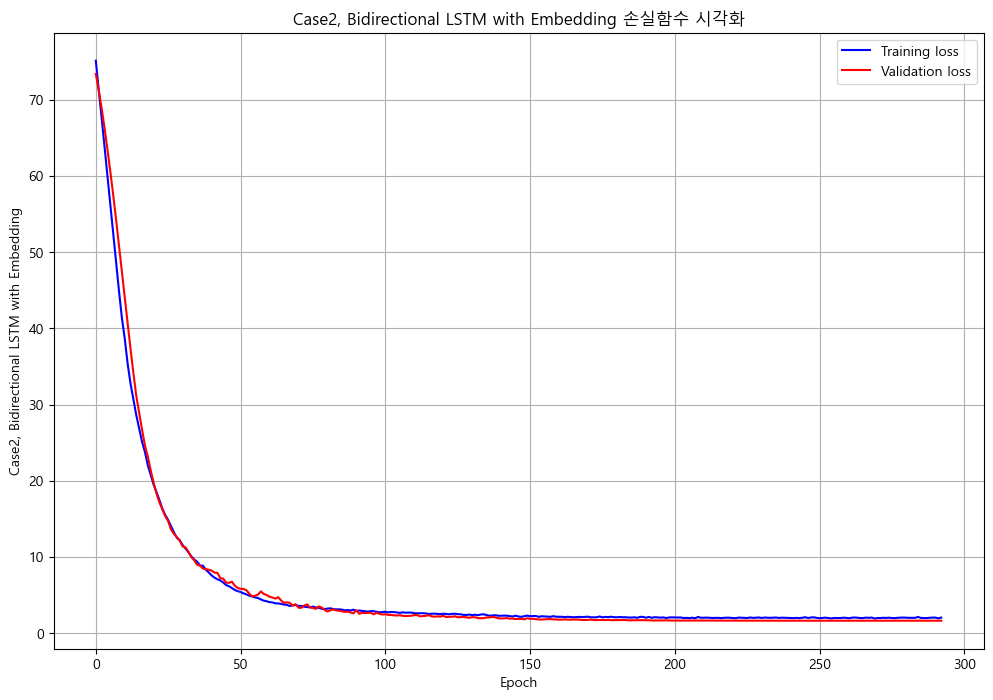

In [164]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case2_bi_label = Model(inputs=[numerical_input, categorical_input], outputs=output)
case2_bi_label.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case2_bi_label_history = case2_bi_label.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case2_bi_label_history, "Case2, Bidirectional LSTM with Embedding")

In [165]:
# case2_bi_label.save("./output/case2_lstm_bi_label_mae.h5")
# case2_bi_label.save("./output/case2_lstm_bi_label_mse.h5")
case2_bi_label.save("./output/case2_lstm_bi_label_mse+rmse.h5")

# 중간점검
- ENSO 라벨링 데이터를 포함시킨 모델의 성능 비교

In [166]:
# 검증데이터 구성
X_compare1_std = case1_dts[376 : 388, :]
X_compare1_std_label = case1_label[376 : 388]
X_compare1_std = np.reshape(X_compare1_std, (1, 12, 5))
X_compare1_std_label = np.reshape(X_compare1_std_label, (1, 12))

Y_compare1_std = case1_dts[388 : 400, -1]
Y_compare1_std_ = Y_compare1_std * case1_std[-1] + case1_mean[-1]

# Case1_uni
Y_HAT_Case1_uni = case1_uni_label.predict([X_compare1_std, X_compare1_std_label])
Y_HAT_Case1_uni_ = Y_HAT_Case1_uni * case1_std[-1] + case1_mean[-1]

# Case1_bi
Y_HAT_Case1_bi = case1_bi_label.predict([X_compare1_std, X_compare1_std_label])
Y_HAT_Case1_bi_ = Y_HAT_Case1_bi * case1_std[-1] + case1_mean[-1]

1/1 [==============================] - 2s 2s/step


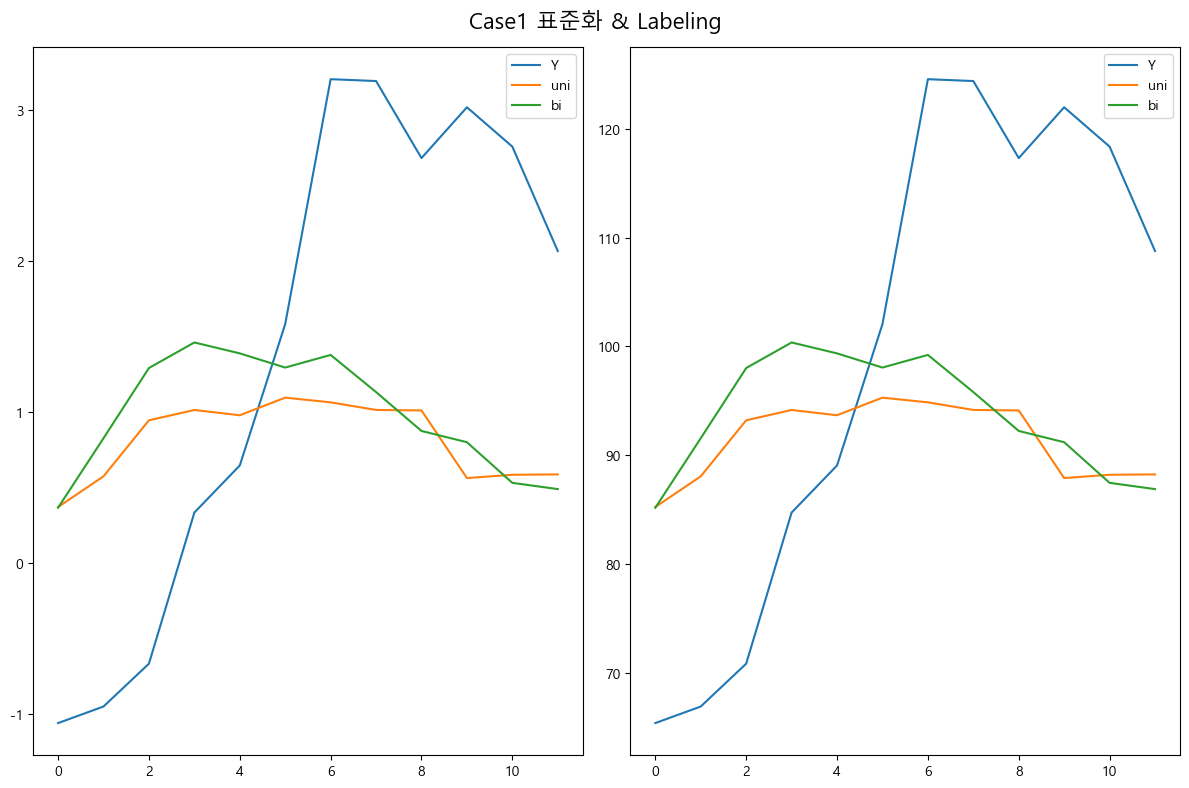

In [167]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare1_std, label="Y")
ax[0].plot(Y_HAT_Case1_uni[0], label="uni")
ax[0].plot(Y_HAT_Case1_bi[0], label="bi")

ax[0].legend()

ax[1].plot(Y_compare1_std_, label="Y")
ax[1].plot(Y_HAT_Case1_uni_[0], label="uni")
ax[1].plot(Y_HAT_Case1_bi_[0], label="bi")

ax[1].legend()

plt.suptitle("Case1 표준화 & Labeling", fontsize=16)

plt.tight_layout()

plt.show()

In [219]:
x_plot_multi, y_plot_multi = multivariate_data(case1_dts, case1_dts[:, -1], 0, None, past_history, future_target, STEP)

x_plot_label = label_split(case1_label, 0, None, past_history, future_target, STEP)

Y_HAT_Case1_uni_plot = case1_uni_label.predict([x_plot_multi, x_plot_label])
# Y_HAT_Case1_bi_plot = case1_bi_label.predict([x_plot_multi, x_plot_label]) 

12/12 [==============================] - 0s 27ms/step


In [244]:
def test_plot(dataset1, dataset2, history_size, target_size):
    data = []
    labels = []

    end_index = len(dataset1) - target_size

    for i in range(end_index):
        data.append(dataset1[i : i + history_size, :])
        labels.append(dataset2[i : i + history_size])
            
    return np.array(data), np.array(labels)

In [245]:
temp1, temp2 = test_plot(case1_dts, case1_label, past_history, future_target)

In [247]:
temp2.shape

(388, 12)

---

In [168]:
# 검증데이터 구성
X_compare1_log = case2_dts[376 : 388, :]
X_compare1_log_label = case2_label[376 : 388]
X_compare1_log = np.reshape(X_compare1_log, (1, 12, 5))
X_compare1_log_label = np.reshape(X_compare1_log_label, (1, 12))

Y_compare1_log = case2_dts[388 : 400, -1]
Y_compare1_log_ = np.sign(Y_compare1_log) * (np.expm1(np.abs(Y_compare1_log)))

# Case2_uni
Y_HAT_Case2_uni = case2_uni_label.predict([X_compare1_log, X_compare1_log_label])
Y_HAT_Case2_uni_ = np.sign(Y_HAT_Case2_uni) * (np.expm1(np.abs(Y_HAT_Case2_uni)))

# Case2_bi
Y_HAT_Case2_bi = case2_bi_label.predict([X_compare1_log, X_compare1_log_label])
Y_HAT_Case2_bi_ = np.sign(Y_HAT_Case2_bi) * (np.expm1(np.abs(Y_HAT_Case2_bi)))

1/1 [==============================] - 2s 2s/step


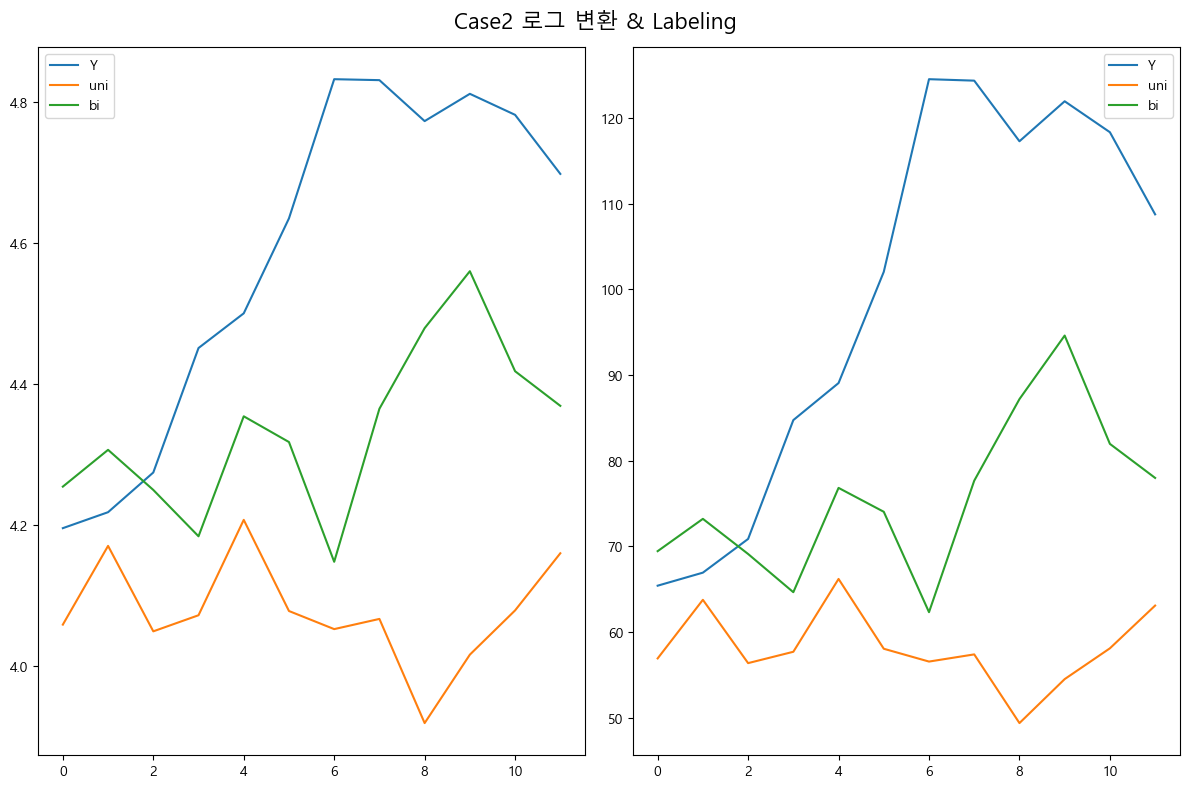

In [169]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare1_log, label="Y")
ax[0].plot(Y_HAT_Case2_uni[0], label="uni")
ax[0].plot(Y_HAT_Case2_bi[0], label="bi")

ax[0].legend()

ax[1].plot(Y_compare1_log_, label="Y")
ax[1].plot(Y_HAT_Case2_uni_[0], label="uni")
ax[1].plot(Y_HAT_Case2_bi_[0], label="bi")

ax[1].legend()

plt.suptitle("Case2 로그 변환 & Labeling", fontsize=16)

plt.tight_layout()

plt.show()

# Case3) DMI & 표준화

## 데이터 전처리

In [170]:
# case3_df = data[['DMI', 'ONI', 'SOI', 'D20_SCTR']]

# case3_dts = case3_df.values

# case3_mean = case3_dts.mean(axis=0)
# case3_std = case3_dts.std(axis=0)
# case3_dts = (case3_dts-case3_mean)/case3_std

In [171]:
case3_df = data[['DMI', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case3_dts = case3_df.values
print(case3_dts.shape)

case3_label = case3_dts[ : , 3]
case3_dts = case3_dts[ : , [0, 1, 2, 4]]

case3_mean = case3_dts.mean(axis=0)
case3_std = case3_dts.std(axis=0)
case3_dts = (case3_dts-case3_mean)/case3_std

print(case3_dts.shape)

(400, 5)
(400, 4)


## 데이터 분리

In [172]:
# # 학습 데이터
# x_train_multi, y_train_multi = multivariate_data(case3_dts, case3_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# # 검증 데이터
# x_val_multi, y_val_multi = multivariate_data(case3_dts, case3_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# # 테스트 데이터
# x_test_multi, y_test_multi = multivariate_data(case3_dts, case3_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

# print(f"학습 데이터 형태: {x_train_multi.shape}")
# print(f"검증 데이터 형태: {x_val_multi.shape}")
# print(f"테스트 데이터 형태: {x_test_multi.shape}")

# print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
# print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

In [173]:
# BUFFER_SIZE = 100

# train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))

# train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
# val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [174]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case3_dts, case3_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case3_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case3_dts, case3_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case3_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case3_dts, case3_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_label = label_split(case3_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"학습 타겟데이터 형태: {y_train_multi.shape}")
print(f"학습 라벨데이터 형태: {x_train_label.shape}")
print("--------------------------------")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"검증 타겟데이터 형태: {y_val_multi.shape}")
print(f"검증 라벨데이터 형태: {x_val_label.shape}")
print("--------------------------------")
print(f"테스트 데이터 형태: {x_test_multi.shape}")
print(f"테스트 타겟데이터 형태: {y_test_multi.shape}")
print(f"테스트 라벨데이터 형태: {x_test_label.shape}")
print("--------------------------------")
print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 4)
학습 타겟데이터 형태: (256, 12)
학습 라벨데이터 형태: (256, 12)
--------------------------------
검증 데이터 형태: (56, 12, 4)
검증 타겟데이터 형태: (56, 12)
검증 라벨데이터 형태: (56, 12)
--------------------------------
테스트 데이터 형태: (16, 12, 4)
테스트 타겟데이터 형태: (16, 12)
테스트 라벨데이터 형태: (16, 12)
--------------------------------
과거 데이터 윈도우 형태: (12, 4)
예측 목표 기간 형태: (12,)


## 모델 학습

### 단방향 LSTM

In [175]:
# from tensorflow.keras.optimizers import RMSprop, Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
# from tensorflow.keras.regularizers import l1_l2
    
# initial_lr = 0.0005

# optimizer = Adam(learning_rate=initial_lr)
# # optimizer = RMSprop(learning_rate=initial_lr, clipvalue=1.0)

# # 학습률 재시작
# lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# # EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# case3_lstm_uni = Sequential()

# case3_lstm_uni.add(LSTM(128, return_sequences=True,
#                           kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                           bias_regularizer=l1_l2(l1=0.005, l2=0.005),    
#                           input_shape=x_train_multi.shape[-2:]))
# case3_lstm_uni.add(BatchNormalization())
# case3_lstm_uni.add(Dropout(0.3))

# case3_lstm_uni.add(LSTM(64, return_sequences=True,
#                           kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                           bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
# case3_lstm_uni.add(BatchNormalization())
# case3_lstm_uni.add(Dropout(0.3))

# case3_lstm_uni.add(LSTM(32, activation='relu',
#                           kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                           bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
# case3_lstm_uni.add(BatchNormalization())
# case3_lstm_uni.add(Dropout(0.3))

# case3_lstm_uni.add(Dense(24, activation='relu'))
# case3_lstm_uni.add(Dense(12))

# case3_lstm_uni.compile(optimizer=optimizer, loss='mse')

# case3_lstm_uni_history = case3_lstm_uni.fit(
#     train_data_multi, 
#     epochs = EPOCHS, 
#     steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
#     validation_data = val_data_multi, 
#     validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
#     callbacks=[
#         lr_restart, 
#         early_stop
#     ])

# plot_train_history(case3_lstm_uni_history, "Case3, Sequential")

In [176]:
# # 리트레이싱 발생
# Y_hat_case3_uni = case3_lstm_uni.predict(x_test_multi)

# Y_hat_case3_uni = Y_hat_case3_uni * case3_std[-1] + case3_mean[-1]

# case3_lstm_uni.save("./output/case3_lstm_uni.h5")

----

Epoch 1/300
16/16 [==============================] - 14s 132ms/step - loss: 22.8516 - root_mean_squared_error: 1.2809 - val_loss: 21.7442 - val_root_mean_squared_error: 0.9802 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 1s 39ms/step - loss: 21.6917 - root_mean_squared_error: 1.1412 - val_loss: 20.9074 - val_root_mean_squared_error: 0.9863 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 1s 41ms/step - loss: 20.6368 - root_mean_squared_error: 1.0552 - val_loss: 20.0315 - val_root_mean_squared_error: 0.9910 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 1s 40ms/step - loss: 19.6633 - root_mean_squared_error: 1.0198 - val_loss: 19.1276 - val_root_mean_squared_error: 0.9949 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 1s 40ms/step - loss: 18.6737 - root_mean_squared_error: 0.9828 - val_loss: 18.2209 - val_root_mean_squared_error: 0.9988 - lr: 5.0000e-04
Epoch 6/300
16/16 [========================

Epoch 44/300
16/16 [==============================] - 1s 42ms/step - loss: 2.7679 - root_mean_squared_error: 0.7754 - val_loss: 3.0875 - val_root_mean_squared_error: 0.9809 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 1s 38ms/step - loss: 2.6734 - root_mean_squared_error: 0.7628 - val_loss: 3.0038 - val_root_mean_squared_error: 0.9727 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 1s 39ms/step - loss: 2.6244 - root_mean_squared_error: 0.7715 - val_loss: 2.9429 - val_root_mean_squared_error: 0.9735 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 1s 40ms/step - loss: 2.5666 - root_mean_squared_error: 0.7714 - val_loss: 2.8835 - val_root_mean_squared_error: 0.9710 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 1s 39ms/step - loss: 2.4956 - root_mean_squared_error: 0.7639 - val_loss: 2.8309 - val_root_mean_squared_error: 0.9743 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 1s 40ms/step - loss: 1.3917 - root_mean_squared_error: 0.7214 - val_loss: 1.8282 - val_root_mean_squared_error: 0.9813 - lr: 2.5000e-04
Epoch 87/300
16/16 [==============================] - 1s 38ms/step - loss: 1.3835 - root_mean_squared_error: 0.7232 - val_loss: 1.8164 - val_root_mean_squared_error: 0.9805 - lr: 2.5000e-04
Epoch 88/300
16/16 [==============================] - 1s 39ms/step - loss: 1.3700 - root_mean_squared_error: 0.7207 - val_loss: 1.8162 - val_root_mean_squared_error: 0.9857 - lr: 2.5000e-04
Epoch 89/300
16/16 [==============================] - 1s 39ms/step - loss: 1.3621 - root_mean_squared_error: 0.7224 - val_loss: 1.8097 - val_root_mean_squared_error: 0.9873 - lr: 2.5000e-04
Epoch 90/300
16/16 [==============================] - 1s 38ms/step - loss: 1.3487 - root_mean_squared_error: 0.7189 - val_loss: 1.8358 - val_root_mean_squared_error: 1.0035 - lr: 2.5000e-04
Epoch 91/300
16/16 [==============================] - 1s 39ms/s

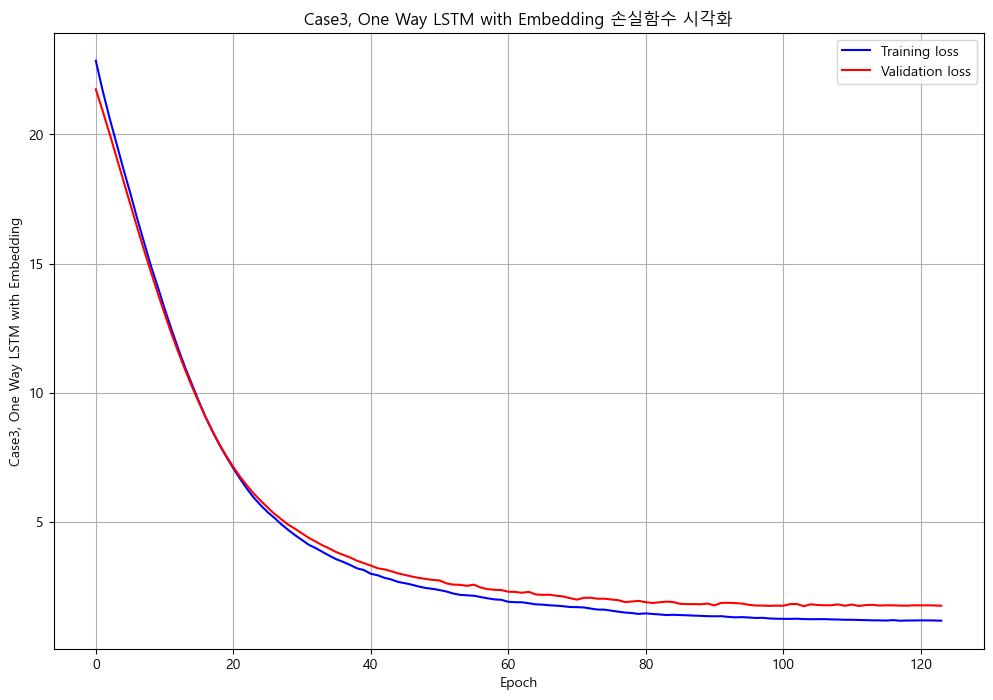

In [177]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case3_uni_label = Model(inputs=[numerical_input, categorical_input], outputs=output)
case3_uni_label.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )


# 모델 학습
case3_uni_label_history = case3_uni_label.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case3_uni_label_history, "Case3, One Way LSTM with Embedding")

In [178]:
# case3_uni_label.save("./output/case3_lstm_uni_label_mae.h5")
# case3_uni_label.save("./output/case3_lstm_uni_label_mse.h5")
case3_uni_label.save("./output/case3_lstm_uni_label_mse+rmse.h5")

### 양방향 LSTM

In [179]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Attention, Concatenate
# from tensorflow.keras.regularizers import l1_l2

# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.optimizers import legacy as legacy_optimizers

# # Attention 레이어 정의
# def attention_layer(inputs):
#     attention = Attention()([inputs, inputs])
#     return Concatenate()([inputs, attention])

# # 옵티마이저 설정
# initial_lr = 0.0005
# optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# # 학습률 재시작
# lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# # EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # 모델 정의
# inputs = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))

# x = Bidirectional(LSTM(128, return_sequences=True,
#                        kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                        bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(inputs)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# x = Bidirectional(LSTM(64, return_sequences=True,
#                        kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                        bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# x = attention_layer(x)

# x = LSTM(32, activation='relu',
#          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#          bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# x = Dense(24, activation='relu',
#           kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#           bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
# outputs = Dense(12)(x)

# case3_lstm_bi = Model(inputs=inputs, outputs=outputs)

# # 모델 빌드 및 컴파일
# case3_lstm_bi.build(input_shape=(None, x_train_multi.shape[1], x_train_multi.shape[2]))
# case3_lstm_bi.compile(optimizer=optimizer, loss='mse')

# # 모델 학습
# case3_lstm_bi_history = case3_lstm_bi.fit(
#     train_data_multi,
#     epochs=EPOCHS,
#     steps_per_epoch=x_train_multi.shape[0] // BATCH_SIZE,
#     validation_data=val_data_multi,
#     validation_steps=x_val_multi.shape[0] // BATCH_SIZE,
#     callbacks=[lr_restart, early_stop]
# )

# plot_train_history(case3_lstm_bi_history, "Case3, Bidirectional")

In [180]:
# Y_hat_case3_bi = case3_lstm_bi.predict(x_test_multi)

# Y_hat_case3_bi = Y_hat_case3_bi * case3_std[-1] + case3_mean[-1]

# case3_lstm_bi.save("./output/case3_lstm_bi.h5")

----

Epoch 1/300
16/16 [==============================] - 13s 222ms/step - loss: 55.9195 - root_mean_squared_error: 1.2596 - val_loss: 53.4594 - val_root_mean_squared_error: 0.9760 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 1s 73ms/step - loss: 52.1234 - root_mean_squared_error: 1.1259 - val_loss: 49.9073 - val_root_mean_squared_error: 0.9785 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 1s 71ms/step - loss: 48.3599 - root_mean_squared_error: 1.0588 - val_loss: 46.2558 - val_root_mean_squared_error: 0.9784 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 1s 73ms/step - loss: 44.6333 - root_mean_squared_error: 1.0167 - val_loss: 42.6441 - val_root_mean_squared_error: 0.9782 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 1s 72ms/step - loss: 41.0008 - root_mean_squared_error: 0.9837 - val_loss: 39.1419 - val_root_mean_squared_error: 0.9783 - lr: 5.0000e-04
Epoch 6/300
16/16 [========================

Epoch 44/300
16/16 [==============================] - 1s 69ms/step - loss: 3.7067 - root_mean_squared_error: 0.8101 - val_loss: 3.9045 - val_root_mean_squared_error: 0.9490 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 1s 70ms/step - loss: 3.5796 - root_mean_squared_error: 0.7851 - val_loss: 3.8179 - val_root_mean_squared_error: 0.9454 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 1s 70ms/step - loss: 3.5300 - root_mean_squared_error: 0.7992 - val_loss: 3.7947 - val_root_mean_squared_error: 0.9651 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 1s 73ms/step - loss: 3.4348 - root_mean_squared_error: 0.7784 - val_loss: 3.7308 - val_root_mean_squared_error: 0.9671 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 1s 71ms/step - loss: 3.3700 - root_mean_squared_error: 0.7764 - val_loss: 3.6337 - val_root_mean_squared_error: 0.9478 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 1s 68ms/step - loss: 1.8658 - root_mean_squared_error: 0.7357 - val_loss: 2.3158 - val_root_mean_squared_error: 1.0049 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 1s 69ms/step - loss: 1.8408 - root_mean_squared_error: 0.7392 - val_loss: 2.3047 - val_root_mean_squared_error: 1.0104 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 1s 71ms/step - loss: 1.8247 - root_mean_squared_error: 0.7432 - val_loss: 2.2463 - val_root_mean_squared_error: 0.9952 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 1s 69ms/step - loss: 1.7959 - root_mean_squared_error: 0.7414 - val_loss: 2.3335 - val_root_mean_squared_error: 1.0478 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 1s 70ms/step - loss: 1.7545 - root_mean_squared_error: 0.7295 - val_loss: 2.1674 - val_root_mean_squared_error: 0.9797 - lr: 5.0000e-04
Epoch 92/300
16/16 [==============================] - 1s 69ms/s

16/16 [==============================] - 1s 71ms/step - loss: 1.1670 - root_mean_squared_error: 0.7037 - val_loss: 1.7503 - val_root_mean_squared_error: 1.0393 - lr: 1.2500e-04
Epoch 129/300
16/16 [==============================] - 1s 70ms/step - loss: 1.1561 - root_mean_squared_error: 0.6990 - val_loss: 1.7706 - val_root_mean_squared_error: 1.0518 - lr: 1.2500e-04
Epoch 130/300
16/16 [==============================] - 1s 71ms/step - loss: 1.1629 - root_mean_squared_error: 0.7077 - val_loss: 1.7425 - val_root_mean_squared_error: 1.0407 - lr: 1.2500e-04
Epoch 131/300
16/16 [==============================] - ETA: 0s - loss: 1.1586 - root_mean_squared_error: 0.7076
Epoch 131: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
16/16 [==============================] - 1s 71ms/step - loss: 1.1586 - root_mean_squared_error: 0.7076 - val_loss: 1.8109 - val_root_mean_squared_error: 1.0749 - lr: 1.2500e-04
Epoch 132/300
16/16 [==============================] - 1s 71ms/step - loss:

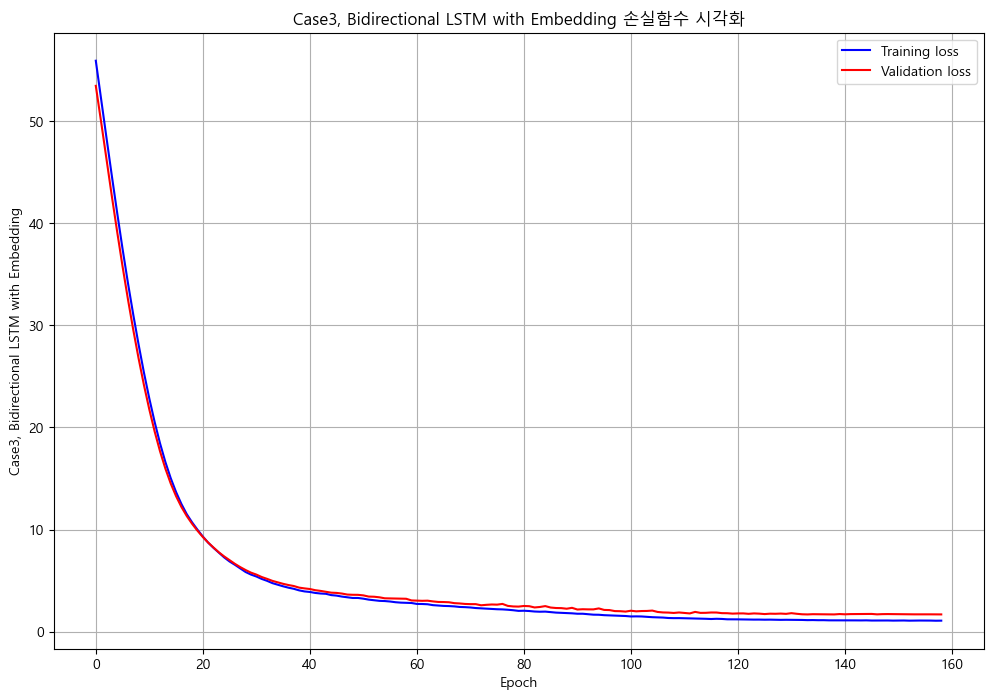

In [181]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case3_bi_label = Model(inputs=[numerical_input, categorical_input], outputs=output)
case3_bi_label.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case3_bi_label_history = case3_bi_label.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case3_bi_label_history, "Case3, Bidirectional LSTM with Embedding")

In [182]:
# case3_bi_label.save("./output/case3_lstm_bi_label_mae.h5")
# case3_bi_label.save("./output/case3_lstm_bi_label_mse.h5")
case3_bi_label.save("./output/case3_lstm_bi_label_mse+rmse.h5")

# Case4) DMI & 로그 변환

## 데이터 전처리

### 부호 유지 로그 변환

In [183]:
# case4_df = data[['DMI', 'ONI', 'SOI', 'D20_SCTR']]
# case4_dts = case4_df.values

# case4_dts = np.sign(case4_dts) * np.log1p(np.abs(case4_dts))

In [184]:
case4_df = data[['DMI', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case4_dts = case4_df.values
print(case4_dts.shape)

case4_label = case4_dts[ : , 3]
case4_dts = case4_dts[ : , [0, 1, 2, 4]]

case4_dts = np.sign(case4_dts) * np.log1p(np.abs(case4_dts))
print(case4_dts.shape)

(400, 5)
(400, 4)


### 데이터 분포 확인

In [185]:
# fig, ax = plt.subplots(4, 2, figsize=(8, 16))

# i = 0

# colors = ["red", "blue", "green", "yellow"]

# for column in case4_df.columns:

#     ax[i][0].hist(case4_df[column], bins=30, label=column, color=colors[i])
#     ax[i][0].grid(axis = "y")
    
#     ax[i][1].hist(case4_dts[:, i], bins=30, label=column, color=colors[i])
#     ax[i][1].grid(axis = "y")

#     i += 1
    
# for j, col_title in enumerate(['원본', '로그 변환']):
#     fig.text(0.29 + j * 0.45, 0.89, col_title, ha='center', va='center', fontsize=16, fontweight='bold')
    
# for i, label in enumerate(['DMI', 'ONI', 'SOI', 'D20_SCTR']):
#     fig.text(0.08, 0.8 - i * 0.2, label, va='center', ha='right', fontsize=16, rotation=90, fontweight='bold')

## 데이터 분리

In [186]:
# # 학습 데이터
# x_train_multi, y_train_multi = multivariate_data(case4_dts, case4_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# # 검증 데이터
# x_val_multi, y_val_multi = multivariate_data(case4_dts, case4_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# # 테스트 데이터
# x_test_multi, y_test_multi = multivariate_data(case4_dts, case4_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

# print(f"학습 데이터 형태: {x_train_multi.shape}")
# print(f"검증 데이터 형태: {x_val_multi.shape}")
# print(f"테스트 데이터 형태: {x_test_multi.shape}")

# print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
# print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

In [187]:
# BUFFER_SIZE = 100

# train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))

# train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
# val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [188]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case4_dts, case4_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case4_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case4_dts, case4_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case4_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case4_dts, case4_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_label = label_split(case4_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"학습 타겟데이터 형태: {y_train_multi.shape}")
print(f"학습 라벨데이터 형태: {x_train_label.shape}")
print("--------------------------------")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"검증 타겟데이터 형태: {y_val_multi.shape}")
print(f"검증 라벨데이터 형태: {x_val_label.shape}")
print("--------------------------------")
print(f"테스트 데이터 형태: {x_test_multi.shape}")
print(f"테스트 타겟데이터 형태: {y_test_multi.shape}")
print(f"테스트 라벨데이터 형태: {x_test_label.shape}")
print("--------------------------------")
print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 4)
학습 타겟데이터 형태: (256, 12)
학습 라벨데이터 형태: (256, 12)
--------------------------------
검증 데이터 형태: (56, 12, 4)
검증 타겟데이터 형태: (56, 12)
검증 라벨데이터 형태: (56, 12)
--------------------------------
테스트 데이터 형태: (16, 12, 4)
테스트 타겟데이터 형태: (16, 12)
테스트 라벨데이터 형태: (16, 12)
--------------------------------
과거 데이터 윈도우 형태: (12, 4)
예측 목표 기간 형태: (12,)


## 모델 학습

### 단방향 LSTM

In [189]:
# from tensorflow.keras.optimizers import RMSprop, Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
# from tensorflow.keras.regularizers import l1_l2
    
# initial_lr = 0.0005

# optimizer = Adam(learning_rate=initial_lr)
# # optimizer = RMSprop(learning_rate=initial_lr, clipvalue=1.0)

# # 학습률 재시작
# lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# # EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# case4_lstm_uni = Sequential()

# case4_lstm_uni.add(LSTM(128, return_sequences=True,
#                           kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                           bias_regularizer=l1_l2(l1=0.005, l2=0.005),    
#                           input_shape=x_train_multi.shape[-2:]))
# case4_lstm_uni.add(BatchNormalization())
# case4_lstm_uni.add(Dropout(0.3))

# case4_lstm_uni.add(LSTM(64, return_sequences=True,
#                           kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                           bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
# case4_lstm_uni.add(BatchNormalization())
# case4_lstm_uni.add(Dropout(0.3))

# case4_lstm_uni.add(LSTM(32, activation='relu',
#                           kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                           bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
# case4_lstm_uni.add(BatchNormalization())
# case4_lstm_uni.add(Dropout(0.3))

# case4_lstm_uni.add(Dense(24, activation='relu'))
# case4_lstm_uni.add(Dense(12))

# case4_lstm_uni.compile(optimizer=optimizer, loss='mse')

# case4_lstm_uni_history = case4_lstm_uni.fit(
#     train_data_multi, 
#     epochs = EPOCHS, 
#     steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
#     validation_data = val_data_multi, 
#     validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
#     callbacks=[
#         lr_restart, 
#         early_stop
#     ])

# plot_train_history(case4_lstm_uni_history, "Case4, Sequential")

In [190]:
# Y_hat_case4_uni = case4_lstm_uni.predict(x_test_multi)

# Y_hat_case4_uni = np.sign(Y_hat_case4_uni) * (np.expm1(np.abs(Y_hat_case4_uni)))

# case4_lstm_uni.save("./output/case4_lstm_uni.h5")

---

Epoch 1/300
16/16 [==============================] - 9s 132ms/step - loss: 41.8486 - root_mean_squared_error: 4.5340 - val_loss: 40.0844 - val_root_mean_squared_error: 4.3618 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 1s 35ms/step - loss: 39.2916 - root_mean_squared_error: 4.2963 - val_loss: 39.3005 - val_root_mean_squared_error: 4.3280 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 1s 38ms/step - loss: 37.0606 - root_mean_squared_error: 4.0913 - val_loss: 38.4969 - val_root_mean_squared_error: 4.2966 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 1s 38ms/step - loss: 35.1710 - root_mean_squared_error: 3.9236 - val_loss: 37.3141 - val_root_mean_squared_error: 4.2232 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 1s 38ms/step - loss: 32.8147 - root_mean_squared_error: 3.6882 - val_loss: 36.0088 - val_root_mean_squared_error: 4.1353 - lr: 5.0000e-04
Epoch 6/300
16/16 [=========================

Epoch 44/300
16/16 [==============================] - 1s 38ms/step - loss: 5.5893 - root_mean_squared_error: 0.8710 - val_loss: 5.4951 - val_root_mean_squared_error: 0.8603 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 1s 39ms/step - loss: 5.3892 - root_mean_squared_error: 0.8432 - val_loss: 5.1127 - val_root_mean_squared_error: 0.7062 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 1s 37ms/step - loss: 5.2882 - root_mean_squared_error: 0.8548 - val_loss: 4.9809 - val_root_mean_squared_error: 0.6903 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 1s 37ms/step - loss: 5.2648 - root_mean_squared_error: 0.9054 - val_loss: 4.9800 - val_root_mean_squared_error: 0.7834 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 1s 39ms/step - loss: 5.2371 - root_mean_squared_error: 0.9681 - val_loss: 4.7783 - val_root_mean_squared_error: 0.7401 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 1s 36ms/step - loss: 2.2178 - root_mean_squared_error: 0.7275 - val_loss: 1.7628 - val_root_mean_squared_error: 0.2987 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 1s 36ms/step - loss: 2.2071 - root_mean_squared_error: 0.7443 - val_loss: 1.7439 - val_root_mean_squared_error: 0.3309 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 1s 36ms/step - loss: 2.1432 - root_mean_squared_error: 0.7277 - val_loss: 1.8287 - val_root_mean_squared_error: 0.4890 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 1s 36ms/step - loss: 2.1190 - root_mean_squared_error: 0.7346 - val_loss: 1.7694 - val_root_mean_squared_error: 0.4537 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 1s 37ms/step - loss: 2.0867 - root_mean_squared_error: 0.7333 - val_loss: 1.7775 - val_root_mean_squared_error: 0.4940 - lr: 5.0000e-04
Epoch 92/300
16/16 [==============================] - 1s 36ms/s

16/16 [==============================] - 1s 37ms/step - loss: 1.4975 - root_mean_squared_error: 0.6455 - val_loss: 1.1874 - val_root_mean_squared_error: 0.3275 - lr: 6.2500e-05
Epoch 128/300
16/16 [==============================] - 1s 35ms/step - loss: 1.5203 - root_mean_squared_error: 0.6662 - val_loss: 1.1727 - val_root_mean_squared_error: 0.3150 - lr: 6.2500e-05
Epoch 129/300
16/16 [==============================] - 1s 35ms/step - loss: 1.5657 - root_mean_squared_error: 0.7023 - val_loss: 1.1782 - val_root_mean_squared_error: 0.3282 - lr: 6.2500e-05
Epoch 130/300
16/16 [==============================] - 1s 36ms/step - loss: 1.4929 - root_mean_squared_error: 0.6522 - val_loss: 1.1646 - val_root_mean_squared_error: 0.3146 - lr: 6.2500e-05
Epoch 131/300
16/16 [==============================] - 1s 37ms/step - loss: 1.5694 - root_mean_squared_error: 0.7084 - val_loss: 1.1586 - val_root_mean_squared_error: 0.3050 - lr: 6.2500e-05
Epoch 132/300
16/16 [==============================] - 1s 3

16/16 [==============================] - 1s 36ms/step - loss: 1.4367 - root_mean_squared_error: 0.6645 - val_loss: 1.0650 - val_root_mean_squared_error: 0.2651 - lr: 3.1250e-05
Epoch 170/300
16/16 [==============================] - 1s 35ms/step - loss: 1.4450 - root_mean_squared_error: 0.6707 - val_loss: 1.0726 - val_root_mean_squared_error: 0.2793 - lr: 3.1250e-05
Epoch 171/300
16/16 [==============================] - 1s 36ms/step - loss: 1.4068 - root_mean_squared_error: 0.6429 - val_loss: 1.0742 - val_root_mean_squared_error: 0.2864 - lr: 3.1250e-05
Epoch 172/300
16/16 [==============================] - 1s 37ms/step - loss: 1.3589 - root_mean_squared_error: 0.6061 - val_loss: 1.0788 - val_root_mean_squared_error: 0.2971 - lr: 3.1250e-05
Epoch 173/300
16/16 [==============================] - 1s 35ms/step - loss: 1.5051 - root_mean_squared_error: 0.7178 - val_loss: 1.0842 - val_root_mean_squared_error: 0.3063 - lr: 3.1250e-05
Epoch 174/300
15/16 [===========================>..] - ETA:

16/16 [==============================] - 1s 35ms/step - loss: 1.3309 - root_mean_squared_error: 0.6104 - val_loss: 1.0379 - val_root_mean_squared_error: 0.2828 - lr: 1.5625e-05
Epoch 212/300
16/16 [==============================] - 1s 37ms/step - loss: 1.3896 - root_mean_squared_error: 0.6572 - val_loss: 1.0365 - val_root_mean_squared_error: 0.2813 - lr: 1.5625e-05
Epoch 213/300
16/16 [==============================] - 1s 35ms/step - loss: 1.3946 - root_mean_squared_error: 0.6610 - val_loss: 1.0371 - val_root_mean_squared_error: 0.2819 - lr: 1.5625e-05
Epoch 214/300
16/16 [==============================] - 1s 36ms/step - loss: 1.3655 - root_mean_squared_error: 0.6392 - val_loss: 1.0357 - val_root_mean_squared_error: 0.2818 - lr: 1.5625e-05
Epoch 215/300
16/16 [==============================] - 1s 36ms/step - loss: 1.4158 - root_mean_squared_error: 0.6778 - val_loss: 1.0304 - val_root_mean_squared_error: 0.2707 - lr: 1.5625e-05
Epoch 216/300
16/16 [==============================] - 1s 3

16/16 [==============================] - 1s 35ms/step - loss: 1.3464 - root_mean_squared_error: 0.6392 - val_loss: 1.0130 - val_root_mean_squared_error: 0.2743 - lr: 1.9531e-06
Epoch 252/300
16/16 [==============================] - 1s 36ms/step - loss: 1.3758 - root_mean_squared_error: 0.6618 - val_loss: 1.0120 - val_root_mean_squared_error: 0.2724 - lr: 1.9531e-06
Epoch 253/300
16/16 [==============================] - 1s 37ms/step - loss: 1.3394 - root_mean_squared_error: 0.6338 - val_loss: 1.0096 - val_root_mean_squared_error: 0.2682 - lr: 1.9531e-06
Epoch 254/300
16/16 [==============================] - 1s 37ms/step - loss: 1.3760 - root_mean_squared_error: 0.6621 - val_loss: 1.0096 - val_root_mean_squared_error: 0.2686 - lr: 1.9531e-06
Epoch 255/300
16/16 [==============================] - 1s 36ms/step - loss: 1.3301 - root_mean_squared_error: 0.6266 - val_loss: 1.0086 - val_root_mean_squared_error: 0.2670 - lr: 1.9531e-06
Epoch 256/300
16/16 [==============================] - 1s 3

16/16 [==============================] - 1s 38ms/step - loss: 1.3515 - root_mean_squared_error: 0.6456 - val_loss: 1.0057 - val_root_mean_squared_error: 0.2665 - lr: 1.0000e-06
Epoch 294/300
16/16 [==============================] - 1s 38ms/step - loss: 1.4097 - root_mean_squared_error: 0.6893 - val_loss: 1.0089 - val_root_mean_squared_error: 0.2726 - lr: 1.0000e-06


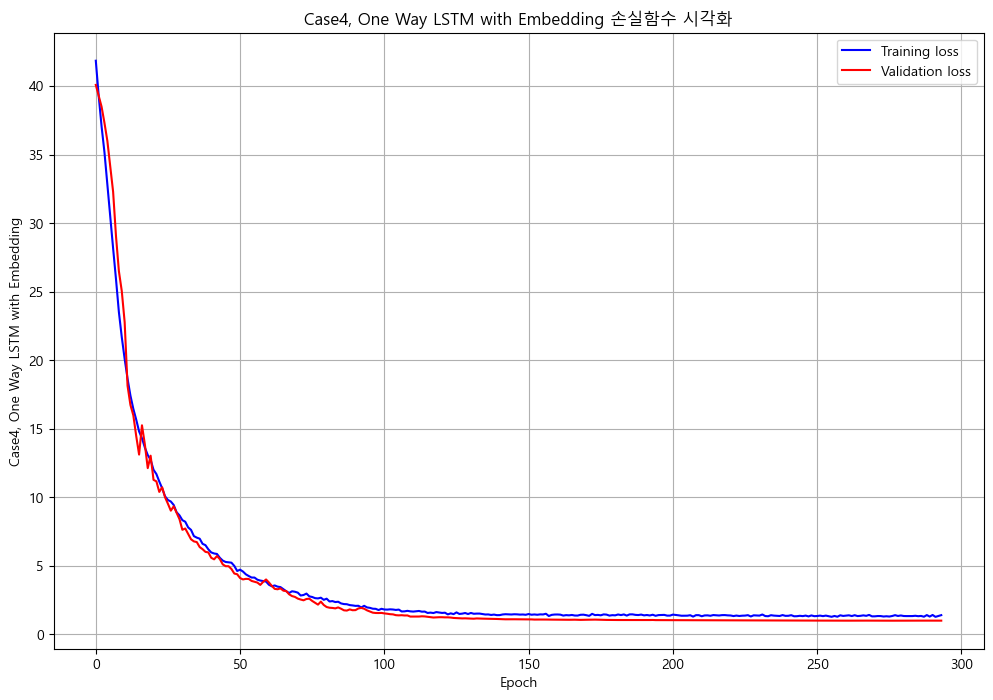

In [191]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case4_uni_label = Model(inputs=[numerical_input, categorical_input], outputs=output)
case4_uni_label.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case4_uni_label_history = case4_uni_label.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case4_uni_label_history, "Case4, One Way LSTM with Embedding")

In [192]:
# case4_uni_label.save("./output/case4_lstm_uni_label_mae.h5")
# case4_uni_label.save("./output/case4_lstm_uni_label_mse.h5")
case4_uni_label.save("./output/case4_lstm_uni_label_mse+rmse.h5")

### 양방향 LSTM

In [193]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Attention, Concatenate
# from tensorflow.keras.regularizers import l1_l2

# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# from tensorflow.keras.optimizers import legacy as legacy_optimizers

# # Attention 레이어 정의
# def attention_layer(inputs):
#     attention = Attention()([inputs, inputs])
#     return Concatenate()([inputs, attention])

# # 옵티마이저 설정
# initial_lr = 0.0005
# optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# # 학습률 재시작
# lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# # EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # 모델 정의
# inputs = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))

# x = Bidirectional(LSTM(128, return_sequences=True,
#                        kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                        bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(inputs)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# x = Bidirectional(LSTM(64, return_sequences=True,
#                        kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#                        bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# x = attention_layer(x)

# x = LSTM(32, activation='relu',
#          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#          bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
# x = BatchNormalization()(x)
# x = Dropout(0.3)(x)

# x = Dense(24, activation='relu',
#           kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
#           bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
# outputs = Dense(12)(x)

# case4_lstm_bi = Model(inputs=inputs, outputs=outputs)

# # 모델 빌드 및 컴파일
# case4_lstm_bi.build(input_shape=(None, x_train_multi.shape[1], x_train_multi.shape[2]))
# case4_lstm_bi.compile(optimizer=optimizer, loss='mse')

# # 모델 학습
# case4_lstm_bi_history = case4_lstm_bi.fit(
#     train_data_multi,
#     epochs=EPOCHS,
#     steps_per_epoch=x_train_multi.shape[0] // BATCH_SIZE,
#     validation_data=val_data_multi,
#     validation_steps=x_val_multi.shape[0] // BATCH_SIZE,
#     callbacks=[lr_restart, early_stop]
# )

# plot_train_history(case4_lstm_bi_history, "Case4, Bidirectional")

In [194]:
# Y_hat_case4_bi = case4_lstm_bi.predict(x_test_multi)

# Y_hat_case4_bi = np.sign(Y_hat_case4_bi) * (np.expm1(np.abs(Y_hat_case4_bi)))

# case4_lstm_bi.save("./output/case4_lstm_bi.h5")

---

Epoch 1/300
16/16 [==============================] - 14s 236ms/step - loss: 74.1061 - root_mean_squared_error: 4.3545 - val_loss: 73.1496 - val_root_mean_squared_error: 4.3703 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 1s 72ms/step - loss: 70.0474 - root_mean_squared_error: 4.1264 - val_loss: 70.3907 - val_root_mean_squared_error: 4.3089 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 1s 72ms/step - loss: 66.1400 - root_mean_squared_error: 3.9268 - val_loss: 67.2857 - val_root_mean_squared_error: 4.2235 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 1s 71ms/step - loss: 62.0027 - root_mean_squared_error: 3.7016 - val_loss: 63.9109 - val_root_mean_squared_error: 4.1134 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 1s 70ms/step - loss: 57.9336 - root_mean_squared_error: 3.4788 - val_loss: 60.5123 - val_root_mean_squared_error: 3.9990 - lr: 5.0000e-04
Epoch 6/300
16/16 [========================

Epoch 44/300
16/16 [==============================] - 1s 69ms/step - loss: 8.1393 - root_mean_squared_error: 0.8529 - val_loss: 7.7459 - val_root_mean_squared_error: 0.6384 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 1s 70ms/step - loss: 7.8567 - root_mean_squared_error: 0.8205 - val_loss: 7.4000 - val_root_mean_squared_error: 0.6216 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 1s 69ms/step - loss: 7.6272 - root_mean_squared_error: 0.8579 - val_loss: 7.2045 - val_root_mean_squared_error: 0.6652 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 1s 69ms/step - loss: 7.4622 - root_mean_squared_error: 0.8896 - val_loss: 7.0088 - val_root_mean_squared_error: 0.6253 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 1s 69ms/step - loss: 7.2538 - root_mean_squared_error: 0.8224 - val_loss: 6.9040 - val_root_mean_squared_error: 0.6564 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 1s 70ms/step - loss: 3.3091 - root_mean_squared_error: 0.7737 - val_loss: 2.8348 - val_root_mean_squared_error: 0.3919 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 1s 69ms/step - loss: 3.2433 - root_mean_squared_error: 0.7722 - val_loss: 2.8240 - val_root_mean_squared_error: 0.4738 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 1s 71ms/step - loss: 3.1937 - root_mean_squared_error: 0.7813 - val_loss: 2.7266 - val_root_mean_squared_error: 0.4088 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 1s 71ms/step - loss: 3.0183 - root_mean_squared_error: 0.7042 - val_loss: 2.8352 - val_root_mean_squared_error: 0.5819 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 1s 69ms/step - loss: 3.0591 - root_mean_squared_error: 0.7527 - val_loss: 2.8666 - val_root_mean_squared_error: 0.6337 - lr: 5.0000e-04
Epoch 92/300
16/16 [==============================] - 1s 72ms/s

16/16 [==============================] - 1s 77ms/step - loss: 1.6599 - root_mean_squared_error: 0.6387 - val_loss: 1.3523 - val_root_mean_squared_error: 0.3395 - lr: 5.0000e-04
Epoch 131/300
16/16 [==============================] - 1s 76ms/step - loss: 1.6579 - root_mean_squared_error: 0.6578 - val_loss: 1.3379 - val_root_mean_squared_error: 0.3547 - lr: 5.0000e-04
Epoch 132/300
16/16 [==============================] - 1s 77ms/step - loss: 1.6185 - root_mean_squared_error: 0.6364 - val_loss: 1.3751 - val_root_mean_squared_error: 0.4085 - lr: 5.0000e-04
Epoch 133/300
16/16 [==============================] - 1s 77ms/step - loss: 1.6622 - root_mean_squared_error: 0.6694 - val_loss: 1.3707 - val_root_mean_squared_error: 0.3961 - lr: 5.0000e-04
Epoch 134/300
16/16 [==============================] - ETA: 0s - loss: 1.6288 - root_mean_squared_error: 0.6631
Epoch 134: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 [==============================] - 1s 76ms/step - loss

16/16 [==============================] - 1s 78ms/step - loss: 1.1236 - root_mean_squared_error: 0.5837 - val_loss: 0.8795 - val_root_mean_squared_error: 0.3158 - lr: 1.2500e-04
Epoch 172/300
16/16 [==============================] - 1s 76ms/step - loss: 1.1050 - root_mean_squared_error: 0.5727 - val_loss: 0.9138 - val_root_mean_squared_error: 0.3635 - lr: 1.2500e-04
Epoch 173/300
16/16 [==============================] - 1s 76ms/step - loss: 1.1438 - root_mean_squared_error: 0.6060 - val_loss: 0.8723 - val_root_mean_squared_error: 0.3098 - lr: 1.2500e-04
Epoch 174/300
16/16 [==============================] - 1s 78ms/step - loss: 1.1304 - root_mean_squared_error: 0.5956 - val_loss: 0.8336 - val_root_mean_squared_error: 0.2523 - lr: 1.2500e-04
Epoch 175/300
16/16 [==============================] - 1s 80ms/step - loss: 1.1324 - root_mean_squared_error: 0.5996 - val_loss: 0.8525 - val_root_mean_squared_error: 0.2802 - lr: 1.2500e-04
Epoch 176/300
16/16 [==============================] - 1s 7

16/16 [==============================] - 1s 69ms/step - loss: 0.9846 - root_mean_squared_error: 0.6006 - val_loss: 0.6897 - val_root_mean_squared_error: 0.2569 - lr: 3.1250e-05
Epoch 213/300
16/16 [==============================] - 1s 67ms/step - loss: 0.9497 - root_mean_squared_error: 0.5711 - val_loss: 0.6915 - val_root_mean_squared_error: 0.2603 - lr: 3.1250e-05
Epoch 214/300
16/16 [==============================] - 1s 70ms/step - loss: 0.9500 - root_mean_squared_error: 0.5715 - val_loss: 0.6896 - val_root_mean_squared_error: 0.2578 - lr: 3.1250e-05
Epoch 215/300
16/16 [==============================] - 1s 83ms/step - loss: 0.9406 - root_mean_squared_error: 0.5639 - val_loss: 0.6909 - val_root_mean_squared_error: 0.2630 - lr: 3.1250e-05
Epoch 216/300
16/16 [==============================] - 1s 65ms/step - loss: 0.9141 - root_mean_squared_error: 0.5407 - val_loss: 0.6863 - val_root_mean_squared_error: 0.2554 - lr: 3.1250e-05
Epoch 217/300
16/16 [==============================] - 1s 7

16/16 [==============================] - 1s 70ms/step - loss: 0.9096 - root_mean_squared_error: 0.5683 - val_loss: 0.6581 - val_root_mean_squared_error: 0.2676 - lr: 3.9063e-06
Epoch 253/300
16/16 [==============================] - 1s 71ms/step - loss: 0.9068 - root_mean_squared_error: 0.5663 - val_loss: 0.6576 - val_root_mean_squared_error: 0.2678 - lr: 3.9063e-06
Epoch 254/300
16/16 [==============================] - 1s 74ms/step - loss: 0.8938 - root_mean_squared_error: 0.5552 - val_loss: 0.6572 - val_root_mean_squared_error: 0.2683 - lr: 3.9063e-06
Epoch 255/300
16/16 [==============================] - 1s 70ms/step - loss: 0.8432 - root_mean_squared_error: 0.5083 - val_loss: 0.6570 - val_root_mean_squared_error: 0.2692 - lr: 3.9063e-06
Epoch 256/300
16/16 [==============================] - 1s 71ms/step - loss: 0.8692 - root_mean_squared_error: 0.5335 - val_loss: 0.6552 - val_root_mean_squared_error: 0.2656 - lr: 3.9063e-06
Epoch 257/300
16/16 [==============================] - 1s 7

16/16 [==============================] - 1s 68ms/step - loss: 0.8854 - root_mean_squared_error: 0.5527 - val_loss: 0.6491 - val_root_mean_squared_error: 0.2632 - lr: 1.0000e-06
Epoch 294/300
16/16 [==============================] - 1s 72ms/step - loss: 0.8875 - root_mean_squared_error: 0.5547 - val_loss: 0.6508 - val_root_mean_squared_error: 0.2665 - lr: 1.0000e-06
Epoch 295/300
16/16 [==============================] - 1s 69ms/step - loss: 0.8722 - root_mean_squared_error: 0.5408 - val_loss: 0.6513 - val_root_mean_squared_error: 0.2674 - lr: 1.0000e-06
Epoch 296/300
16/16 [==============================] - 1s 71ms/step - loss: 0.8679 - root_mean_squared_error: 0.5368 - val_loss: 0.6527 - val_root_mean_squared_error: 0.2697 - lr: 1.0000e-06
Epoch 297/300
16/16 [==============================] - 1s 71ms/step - loss: 0.8883 - root_mean_squared_error: 0.5553 - val_loss: 0.6497 - val_root_mean_squared_error: 0.2643 - lr: 1.0000e-06
Epoch 298/300
16/16 [==============================] - 1s 6

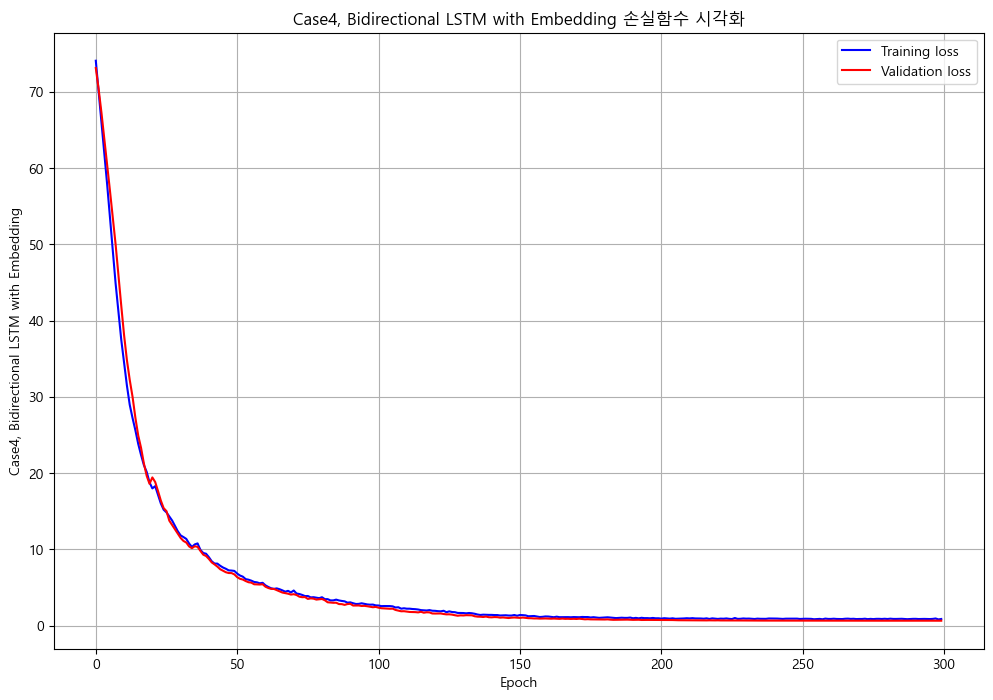

In [195]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case4_bi_label = Model(inputs=[numerical_input, categorical_input], outputs=output)
case4_bi_label.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case4_bi_label_history = case4_bi_label.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case4_bi_label_history, "Case4, Bidirectional LSTM with Embedding")

In [197]:
# case4_bi_label.save("./output/case4_lstm_bi_label_mae.h5")
# case4_bi_label.save("./output/case4_lstm_bi_label_mse.h5")
case4_bi_label.save("./output/case4_lstm_bi_label_mse+rmse.h5")

# 중간점검

In [198]:
# 검증데이터 구성
X_compare2_std = case3_dts[376 : 388, :]
X_compare2_std_label = case3_label[376 : 388]
X_compare2_std = np.reshape(X_compare2_std, (1, 12, 4))
X_compare2_std_label = np.reshape(X_compare2_std_label, (1, 12))

Y_compare2_std = case3_dts[388 : 400, -1]
Y_compare2_std_ = Y_compare2_std * case3_std[-1] + case3_mean[-1]

# Case3_uni
Y_HAT_Case3_uni = case3_uni_label.predict([X_compare2_std, X_compare2_std_label])
Y_HAT_Case3_uni_ = Y_HAT_Case3_uni * case3_std[-1] + case3_mean[-1]

# Case3_bi
Y_HAT_Case3_bi = case3_bi_label.predict([X_compare2_std, X_compare2_std_label])
Y_HAT_Case3_bi_ = Y_HAT_Case3_bi * case3_std[-1] + case3_mean[-1]

1/1 [==============================] - 2s 2s/step


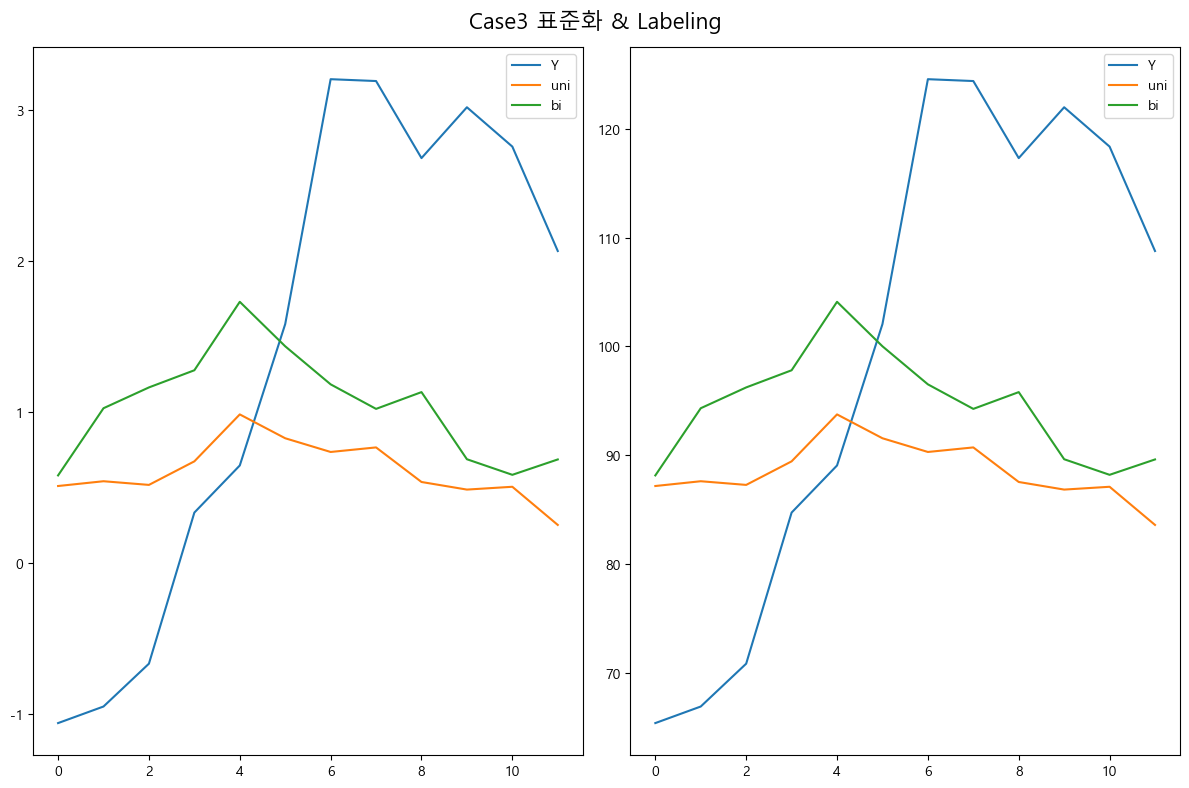

In [199]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare2_std, label="Y")
ax[0].plot(Y_HAT_Case3_uni[0], label="uni")
ax[0].plot(Y_HAT_Case3_bi[0], label="bi")

ax[0].legend()

ax[1].plot(Y_compare2_std_, label="Y")
ax[1].plot(Y_HAT_Case3_uni_[0], label="uni")
ax[1].plot(Y_HAT_Case3_bi_[0], label="bi")

ax[1].legend()

plt.suptitle("Case3 표준화 & Labeling", fontsize=16)

plt.tight_layout()

plt.show()

---

In [200]:
# 검증데이터 구성
X_compare2_log = case4_dts[376 : 388, :]
X_compare2_log_label = case4_label[376 : 388]
X_compare2_log = np.reshape(X_compare2_log, (1, 12, 4))
X_compare2_log_label = np.reshape(X_compare2_log_label, (1, 12))

Y_compare2_log = case4_dts[388 : 400, -1]
Y_compare2_log_ = np.sign(Y_compare2_log) * (np.expm1(np.abs(Y_compare2_log)))

# Case2_uni
Y_HAT_Case4_uni = case4_uni_label.predict([X_compare2_log, X_compare2_log_label])
Y_HAT_Case4_uni_ = np.sign(Y_HAT_Case4_uni) * (np.expm1(np.abs(Y_HAT_Case4_uni)))

# Case2_bi
Y_HAT_Case4_bi = case4_bi_label.predict([X_compare2_log, X_compare2_log_label])
Y_HAT_Case4_bi_ = np.sign(Y_HAT_Case4_bi) * (np.expm1(np.abs(Y_HAT_Case4_bi)))

1/1 [==============================] - 2s 2s/step


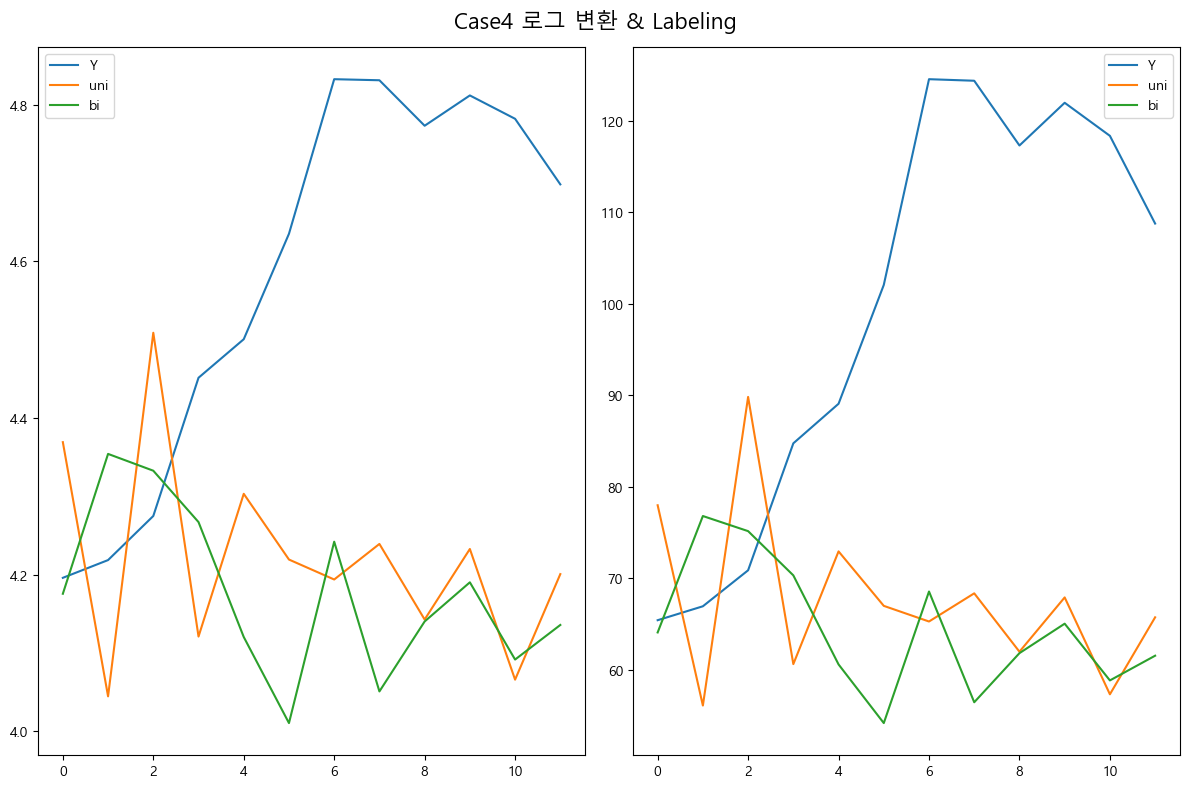

In [201]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare2_log, label="Y")
ax[0].plot(Y_HAT_Case4_uni[0], label="uni")
ax[0].plot(Y_HAT_Case4_bi[0], label="bi")

ax[0].legend()

ax[1].plot(Y_compare2_log_, label="Y")
ax[1].plot(Y_HAT_Case4_uni_[0], label="uni")
ax[1].plot(Y_HAT_Case4_bi_[0], label="bi")

ax[1].legend()

plt.suptitle("Case4 로그 변환 & Labeling", fontsize=16)

plt.tight_layout()

plt.show()

# Case5) 3개 다 & 표준화

## 데이터 전처리

In [202]:
case5_df = data[['WTIO', 'SETIO', 'DMI', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case5_dts = case5_df.values
print(case5_dts.shape)

case5_label = case5_dts[ : , 5]
case5_dts = case5_dts[ : , [0, 1, 2, 3, 4, 6]]

case5_mean = case5_dts.mean(axis=0)
case5_std = case5_dts.std(axis=0)
case5_dts = (case5_dts-case5_mean)/case5_std

print(case5_dts.shape)

(400, 7)
(400, 6)


## 데이터 분리

In [203]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case5_dts, case5_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case5_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case5_dts, case5_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case5_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case5_dts, case5_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_label = label_split(case5_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"학습 타겟데이터 형태: {y_train_multi.shape}")
print(f"학습 라벨데이터 형태: {x_train_label.shape}")
print("--------------------------------")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"검증 타겟데이터 형태: {y_val_multi.shape}")
print(f"검증 라벨데이터 형태: {x_val_label.shape}")
print("--------------------------------")
print(f"테스트 데이터 형태: {x_test_multi.shape}")
print(f"테스트 타겟데이터 형태: {y_test_multi.shape}")
print(f"테스트 라벨데이터 형태: {x_test_label.shape}")
print("--------------------------------")
print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 6)
학습 타겟데이터 형태: (256, 12)
학습 라벨데이터 형태: (256, 12)
--------------------------------
검증 데이터 형태: (56, 12, 6)
검증 타겟데이터 형태: (56, 12)
검증 라벨데이터 형태: (56, 12)
--------------------------------
테스트 데이터 형태: (16, 12, 6)
테스트 타겟데이터 형태: (16, 12)
테스트 라벨데이터 형태: (16, 12)
--------------------------------
과거 데이터 윈도우 형태: (12, 6)
예측 목표 기간 형태: (12,)


## 모델 학습

### 단방향 LSTM

Epoch 1/300
16/16 [==============================] - 9s 140ms/step - loss: 23.3153 - root_mean_squared_error: 1.3479 - val_loss: 22.0537 - val_root_mean_squared_error: 0.9743 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 1s 52ms/step - loss: 22.1940 - root_mean_squared_error: 1.2100 - val_loss: 21.2469 - val_root_mean_squared_error: 0.9746 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 1s 52ms/step - loss: 21.2071 - root_mean_squared_error: 1.1408 - val_loss: 20.4018 - val_root_mean_squared_error: 0.9731 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 1s 52ms/step - loss: 20.2131 - root_mean_squared_error: 1.0790 - val_loss: 19.5358 - val_root_mean_squared_error: 0.9742 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 1s 51ms/step - loss: 19.2261 - root_mean_squared_error: 1.0243 - val_loss: 18.6608 - val_root_mean_squared_error: 0.9742 - lr: 5.0000e-04
Epoch 6/300
16/16 [=========================

Epoch 44/300
16/16 [==============================] - 1s 49ms/step - loss: 2.8910 - root_mean_squared_error: 0.7672 - val_loss: 3.3268 - val_root_mean_squared_error: 1.0325 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 1s 51ms/step - loss: 2.8263 - root_mean_squared_error: 0.7745 - val_loss: 3.1578 - val_root_mean_squared_error: 0.9850 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 1s 53ms/step - loss: 2.7498 - root_mean_squared_error: 0.7707 - val_loss: 3.1139 - val_root_mean_squared_error: 0.9972 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 1s 56ms/step - loss: 2.6617 - root_mean_squared_error: 0.7598 - val_loss: 3.0638 - val_root_mean_squared_error: 1.0089 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 1s 54ms/step - loss: 2.5783 - root_mean_squared_error: 0.7515 - val_loss: 2.9512 - val_root_mean_squared_error: 0.9852 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 1s 55ms/step - loss: 1.3526 - root_mean_squared_error: 0.7200 - val_loss: 1.8176 - val_root_mean_squared_error: 0.9971 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 1s 53ms/step - loss: 1.3709 - root_mean_squared_error: 0.7439 - val_loss: 1.8234 - val_root_mean_squared_error: 1.0033 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 1s 52ms/step - loss: 1.3706 - root_mean_squared_error: 0.7462 - val_loss: 1.8315 - val_root_mean_squared_error: 1.0123 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 1s 52ms/step - loss: 1.3297 - root_mean_squared_error: 0.7277 - val_loss: 1.8253 - val_root_mean_squared_error: 1.0191 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 1s 50ms/step - loss: 1.2750 - root_mean_squared_error: 0.7072 - val_loss: 1.6990 - val_root_mean_squared_error: 0.9679 - lr: 5.0000e-04
Epoch 92/300
16/16 [==============================] - 1s 50ms/s

16/16 [==============================] - 1s 49ms/step - loss: 0.8493 - root_mean_squared_error: 0.6969 - val_loss: 1.3511 - val_root_mean_squared_error: 0.9956 - lr: 2.5000e-04
Epoch 130/300
16/16 [==============================] - 1s 47ms/step - loss: 0.8500 - root_mean_squared_error: 0.7020 - val_loss: 1.3438 - val_root_mean_squared_error: 0.9947 - lr: 2.5000e-04
Epoch 131/300
16/16 [==============================] - 1s 46ms/step - loss: 0.8477 - root_mean_squared_error: 0.7039 - val_loss: 1.3738 - val_root_mean_squared_error: 1.0122 - lr: 2.5000e-04
Epoch 132/300
15/16 [===========================>..] - ETA: 0s - loss: 0.8434 - root_mean_squared_error: 0.7040
Epoch 132: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
16/16 [==============================] - 1s 46ms/step - loss: 0.8374 - root_mean_squared_error: 0.6998 - val_loss: 1.4075 - val_root_mean_squared_error: 1.0299 - lr: 2.5000e-04
Epoch 133/300
16/16 [==============================] - 1s 49ms/step - loss

Epoch 168/300
16/16 [==============================] - 1s 53ms/step - loss: 0.7637 - root_mean_squared_error: 0.6859 - val_loss: 1.3075 - val_root_mean_squared_error: 1.0072 - lr: 7.8125e-06
Epoch 169/300
16/16 [==============================] - 1s 50ms/step - loss: 0.7566 - root_mean_squared_error: 0.6809 - val_loss: 1.3071 - val_root_mean_squared_error: 1.0071 - lr: 7.8125e-06
Epoch 170/300
16/16 [==============================] - 1s 47ms/step - loss: 0.7629 - root_mean_squared_error: 0.6857 - val_loss: 1.3070 - val_root_mean_squared_error: 1.0072 - lr: 7.8125e-06
Epoch 171/300
16/16 [==============================] - 1s 51ms/step - loss: 0.7614 - root_mean_squared_error: 0.6848 - val_loss: 1.3132 - val_root_mean_squared_error: 1.0104 - lr: 7.8125e-06
Epoch 172/300
15/16 [===========================>..] - ETA: 0s - loss: 0.7681 - root_mean_squared_error: 0.6898
Epoch 172: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
16/16 [==============================] - 1s 46

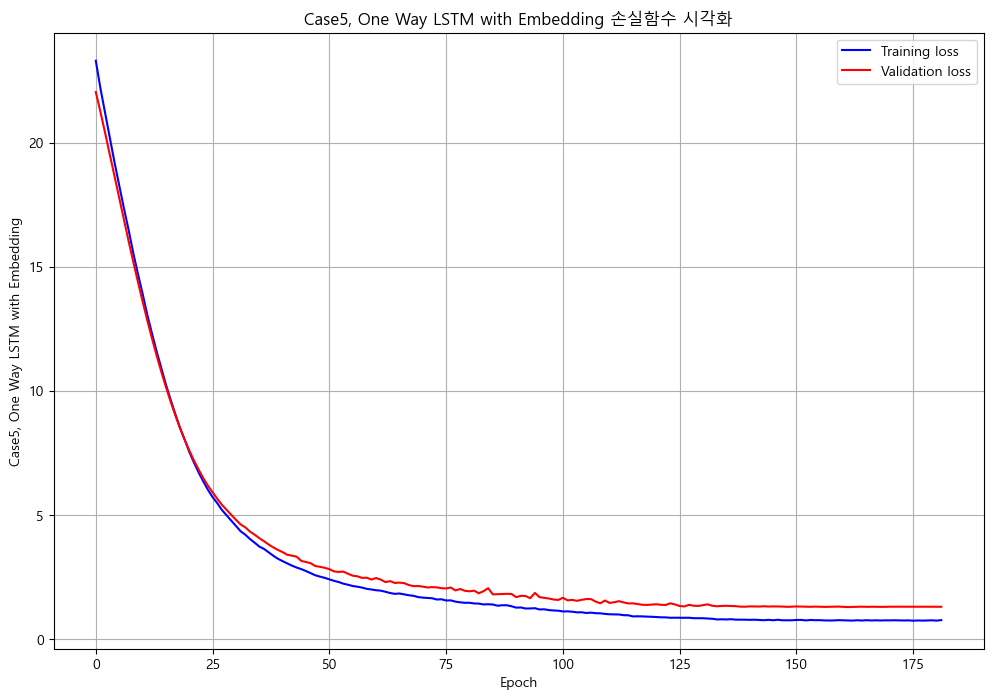

In [204]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case5_uni_label = Model(inputs=[numerical_input, categorical_input], outputs=output)
case5_uni_label.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case5_uni_label_history = case5_uni_label.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case5_uni_label_history, "Case5, One Way LSTM with Embedding")

In [205]:
# case5_uni_label.save("./output/case5_lstm_uni_label_mae.h5")
# case5_uni_label.save("./output/case5_lstm_uni_label_mse.h5")
case5_uni_label.save("./output/case5_lstm_uni_label_mse+rmse.h5")

### 양방향 LSTM

Epoch 1/300
16/16 [==============================] - 12s 229ms/step - loss: 56.2906 - root_mean_squared_error: 1.2119 - val_loss: 53.8164 - val_root_mean_squared_error: 0.9760 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 2s 108ms/step - loss: 52.3114 - root_mean_squared_error: 1.1041 - val_loss: 50.0471 - val_root_mean_squared_error: 0.9796 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 2s 101ms/step - loss: 48.3791 - root_mean_squared_error: 1.0329 - val_loss: 46.2716 - val_root_mean_squared_error: 0.9853 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 2s 103ms/step - loss: 44.5319 - root_mean_squared_error: 0.9913 - val_loss: 42.5594 - val_root_mean_squared_error: 0.9899 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 2s 103ms/step - loss: 40.8436 - root_mean_squared_error: 0.9799 - val_loss: 38.9774 - val_root_mean_squared_error: 0.9942 - lr: 5.0000e-04
Epoch 6/300
16/16 [====================

Epoch 44/300
16/16 [==============================] - 2s 96ms/step - loss: 3.6190 - root_mean_squared_error: 0.7656 - val_loss: 3.9564 - val_root_mean_squared_error: 0.9776 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 2s 100ms/step - loss: 3.5882 - root_mean_squared_error: 0.7849 - val_loss: 3.9345 - val_root_mean_squared_error: 0.9932 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 2s 105ms/step - loss: 3.5001 - root_mean_squared_error: 0.7671 - val_loss: 3.8170 - val_root_mean_squared_error: 0.9741 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 2s 102ms/step - loss: 3.4116 - root_mean_squared_error: 0.7586 - val_loss: 3.7626 - val_root_mean_squared_error: 0.9751 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 2s 98ms/step - loss: 3.3623 - root_mean_squared_error: 0.7620 - val_loss: 3.6740 - val_root_mean_squared_error: 0.9548 - lr: 5.0000e-04
Epoch 49/300
16/16 [===========================

Epoch 87/300
16/16 [==============================] - 2s 103ms/step - loss: 1.8519 - root_mean_squared_error: 0.7300 - val_loss: 2.2605 - val_root_mean_squared_error: 0.9781 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 2s 104ms/step - loss: 1.8069 - root_mean_squared_error: 0.7190 - val_loss: 2.2134 - val_root_mean_squared_error: 0.9672 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 2s 98ms/step - loss: 1.8052 - root_mean_squared_error: 0.7341 - val_loss: 2.1816 - val_root_mean_squared_error: 0.9646 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 2s 100ms/step - loss: 1.7525 - root_mean_squared_error: 0.7159 - val_loss: 2.1988 - val_root_mean_squared_error: 0.9866 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 2s 101ms/step - loss: 1.7084 - root_mean_squared_error: 0.7048 - val_loss: 2.1195 - val_root_mean_squared_error: 0.9611 - lr: 5.0000e-04
Epoch 92/300
16/16 [==========================

Epoch 129/300
16/16 [==============================] - 2s 104ms/step - loss: 1.0392 - root_mean_squared_error: 0.6924 - val_loss: 1.5047 - val_root_mean_squared_error: 0.9744 - lr: 2.5000e-04
Epoch 130/300
16/16 [==============================] - 2s 100ms/step - loss: 1.0417 - root_mean_squared_error: 0.6997 - val_loss: 1.5026 - val_root_mean_squared_error: 0.9762 - lr: 2.5000e-04
Epoch 131/300
16/16 [==============================] - 2s 102ms/step - loss: 1.0228 - root_mean_squared_error: 0.6905 - val_loss: 1.5318 - val_root_mean_squared_error: 0.9952 - lr: 2.5000e-04
Epoch 132/300
16/16 [==============================] - 2s 102ms/step - loss: 1.0269 - root_mean_squared_error: 0.6995 - val_loss: 1.6335 - val_root_mean_squared_error: 1.0490 - lr: 2.5000e-04
Epoch 133/300
16/16 [==============================] - 2s 101ms/step - loss: 1.0234 - root_mean_squared_error: 0.7037 - val_loss: 1.4782 - val_root_mean_squared_error: 0.9777 - lr: 2.5000e-04
Epoch 134/300
16/16 [===================

Epoch 170/300
16/16 [==============================] - 2s 101ms/step - loss: 0.7688 - root_mean_squared_error: 0.6754 - val_loss: 1.3061 - val_root_mean_squared_error: 0.9973 - lr: 6.2500e-05
Epoch 171/300
16/16 [==============================] - 2s 99ms/step - loss: 0.7790 - root_mean_squared_error: 0.6847 - val_loss: 1.3288 - val_root_mean_squared_error: 1.0096 - lr: 6.2500e-05
Epoch 172/300
16/16 [==============================] - 2s 101ms/step - loss: 0.7685 - root_mean_squared_error: 0.6782 - val_loss: 1.2955 - val_root_mean_squared_error: 0.9943 - lr: 6.2500e-05
Epoch 173/300
16/16 [==============================] - 2s 99ms/step - loss: 0.7722 - root_mean_squared_error: 0.6828 - val_loss: 1.2925 - val_root_mean_squared_error: 0.9936 - lr: 6.2500e-05
Epoch 174/300
16/16 [==============================] - 2s 99ms/step - loss: 0.7629 - root_mean_squared_error: 0.6771 - val_loss: 1.2665 - val_root_mean_squared_error: 0.9814 - lr: 6.2500e-05
Epoch 175/300
16/16 [======================

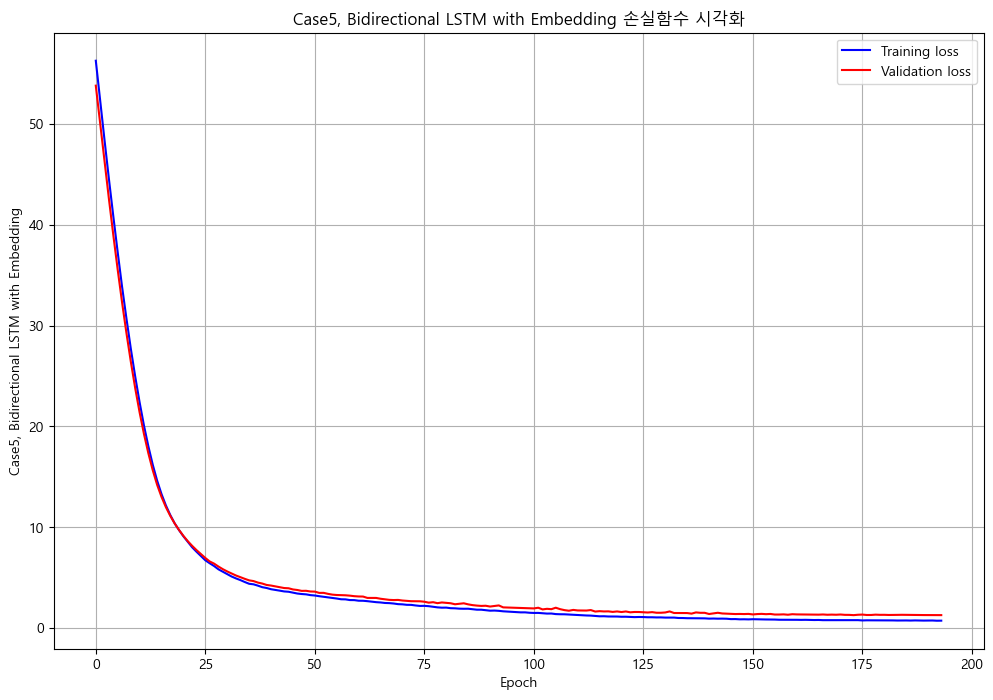

In [206]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case5_bi_label = Model(inputs=[numerical_input, categorical_input], outputs=output)
case5_bi_label.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case5_bi_label_history = case5_bi_label.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case5_bi_label_history, "Case5, Bidirectional LSTM with Embedding")

In [207]:
# case5_bi_label.save("./output/case5_lstm_bi_label_mae.h5")
# case5_bi_label.save("./output/case5_lstm_bi_label_mse.h5")
case5_bi_label.save("./output/case5_lstm_bi_label_mse+rmse.h5")

# Case6) 3개 다 & 로그 변환

## 데이터 전처리

### 부호 유지 로그 변환

In [208]:
case6_df = data[['WTIO', 'SETIO', 'DMI', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case6_dts = case6_df.values
print(case6_dts.shape)

case6_label = case6_dts[ : , 5]
case6_dts = case6_dts[ : , [0, 1, 2, 3, 4, 6]]

case6_dts = np.sign(case6_dts) * np.log1p(np.abs(case6_dts))
print(case6_dts.shape)

(400, 7)
(400, 6)


## 데이터 분리

In [209]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case6_dts, case6_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case6_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case6_dts, case6_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case6_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case6_dts, case6_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_label = label_split(case6_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"학습 타겟데이터 형태: {y_train_multi.shape}")
print(f"학습 라벨데이터 형태: {x_train_label.shape}")
print("--------------------------------")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"검증 타겟데이터 형태: {y_val_multi.shape}")
print(f"검증 라벨데이터 형태: {x_val_label.shape}")
print("--------------------------------")
print(f"테스트 데이터 형태: {x_test_multi.shape}")
print(f"테스트 타겟데이터 형태: {y_test_multi.shape}")
print(f"테스트 라벨데이터 형태: {x_test_label.shape}")
print("--------------------------------")
print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 6)
학습 타겟데이터 형태: (256, 12)
학습 라벨데이터 형태: (256, 12)
--------------------------------
검증 데이터 형태: (56, 12, 6)
검증 타겟데이터 형태: (56, 12)
검증 라벨데이터 형태: (56, 12)
--------------------------------
테스트 데이터 형태: (16, 12, 6)
테스트 타겟데이터 형태: (16, 12)
테스트 라벨데이터 형태: (16, 12)
--------------------------------
과거 데이터 윈도우 형태: (12, 6)
예측 목표 기간 형태: (12,)


## 모델 학습

### 단방향 LSTM

Epoch 1/300
16/16 [==============================] - 9s 138ms/step - loss: 42.0808 - root_mean_squared_error: 4.5260 - val_loss: 40.4837 - val_root_mean_squared_error: 4.3740 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 1s 50ms/step - loss: 40.0659 - root_mean_squared_error: 4.3528 - val_loss: 39.5247 - val_root_mean_squared_error: 4.3219 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 1s 50ms/step - loss: 38.0983 - root_mean_squared_error: 4.1834 - val_loss: 38.3278 - val_root_mean_squared_error: 4.2445 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 1s 47ms/step - loss: 36.1479 - root_mean_squared_error: 4.0120 - val_loss: 36.7563 - val_root_mean_squared_error: 4.1233 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 1s 47ms/step - loss: 34.2474 - root_mean_squared_error: 3.8418 - val_loss: 35.1985 - val_root_mean_squared_error: 4.0016 - lr: 5.0000e-04
Epoch 6/300
16/16 [=========================

Epoch 44/300
16/16 [==============================] - 1s 47ms/step - loss: 5.6478 - root_mean_squared_error: 0.8810 - val_loss: 5.1568 - val_root_mean_squared_error: 0.5887 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 1s 47ms/step - loss: 5.3651 - root_mean_squared_error: 0.8035 - val_loss: 4.9494 - val_root_mean_squared_error: 0.5746 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 1s 51ms/step - loss: 5.2986 - root_mean_squared_error: 0.8679 - val_loss: 4.8381 - val_root_mean_squared_error: 0.6034 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 1s 45ms/step - loss: 5.2470 - root_mean_squared_error: 0.9112 - val_loss: 4.5918 - val_root_mean_squared_error: 0.4866 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 1s 47ms/step - loss: 4.9538 - root_mean_squared_error: 0.8137 - val_loss: 4.4519 - val_root_mean_squared_error: 0.4879 - lr: 5.0000e-04
Epoch 49/300
16/16 [==============================

16/16 [==============================] - 1s 53ms/step - loss: 2.3983 - root_mean_squared_error: 0.8054 - val_loss: 1.8954 - val_root_mean_squared_error: 0.4013 - lr: 5.0000e-04
Epoch 88/300
16/16 [==============================] - 1s 57ms/step - loss: 2.3263 - root_mean_squared_error: 0.7785 - val_loss: 1.8640 - val_root_mean_squared_error: 0.4198 - lr: 5.0000e-04
Epoch 89/300
16/16 [==============================] - 1s 55ms/step - loss: 2.2073 - root_mean_squared_error: 0.7498 - val_loss: 1.8448 - val_root_mean_squared_error: 0.4896 - lr: 5.0000e-04
Epoch 90/300
16/16 [==============================] - 1s 45ms/step - loss: 2.1262 - root_mean_squared_error: 0.7312 - val_loss: 1.8315 - val_root_mean_squared_error: 0.5109 - lr: 5.0000e-04
Epoch 91/300
16/16 [==============================] - 1s 47ms/step - loss: 2.0511 - root_mean_squared_error: 0.7112 - val_loss: 1.7455 - val_root_mean_squared_error: 0.4724 - lr: 5.0000e-04
Epoch 92/300
16/16 [==============================] - 1s 48ms/s

16/16 [==============================] - 1s 46ms/step - loss: 1.4215 - root_mean_squared_error: 0.6975 - val_loss: 1.0071 - val_root_mean_squared_error: 0.2642 - lr: 2.5000e-04
Epoch 130/300
16/16 [==============================] - 1s 50ms/step - loss: 1.3331 - root_mean_squared_error: 0.6329 - val_loss: 1.0123 - val_root_mean_squared_error: 0.2974 - lr: 2.5000e-04
Epoch 131/300
16/16 [==============================] - 1s 51ms/step - loss: 1.3567 - root_mean_squared_error: 0.6597 - val_loss: 0.9946 - val_root_mean_squared_error: 0.2887 - lr: 2.5000e-04
Epoch 132/300
16/16 [==============================] - 1s 48ms/step - loss: 1.3596 - root_mean_squared_error: 0.6720 - val_loss: 0.9788 - val_root_mean_squared_error: 0.2800 - lr: 2.5000e-04
Epoch 133/300
16/16 [==============================] - 1s 48ms/step - loss: 1.3431 - root_mean_squared_error: 0.6697 - val_loss: 1.0301 - val_root_mean_squared_error: 0.3770 - lr: 2.5000e-04
Epoch 134/300
16/16 [==============================] - 1s 5

16/16 [==============================] - 1s 49ms/step - loss: 0.9842 - root_mean_squared_error: 0.5805 - val_loss: 0.7251 - val_root_mean_squared_error: 0.2846 - lr: 1.2500e-04
Epoch 172/300
16/16 [==============================] - 1s 47ms/step - loss: 0.9824 - root_mean_squared_error: 0.5836 - val_loss: 0.7253 - val_root_mean_squared_error: 0.2862 - lr: 1.2500e-04
Epoch 173/300
15/16 [===========================>..] - ETA: 0s - loss: 1.0073 - root_mean_squared_error: 0.6028
Epoch 173: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
16/16 [==============================] - 1s 47ms/step - loss: 1.0107 - root_mean_squared_error: 0.6057 - val_loss: 0.7231 - val_root_mean_squared_error: 0.2837 - lr: 1.2500e-04
Epoch 174/300
16/16 [==============================] - 1s 44ms/step - loss: 0.9954 - root_mean_squared_error: 0.5972 - val_loss: 0.7084 - val_root_mean_squared_error: 0.2720 - lr: 6.2500e-05
Epoch 175/300
16/16 [==============================] - 1s 48ms/step - loss:

16/16 [==============================] - 1s 44ms/step - loss: 0.9666 - root_mean_squared_error: 0.6290 - val_loss: 0.6465 - val_root_mean_squared_error: 0.2746 - lr: 3.1250e-05
Epoch 213/300
16/16 [==============================] - 1s 46ms/step - loss: 0.9355 - root_mean_squared_error: 0.6043 - val_loss: 0.6463 - val_root_mean_squared_error: 0.2778 - lr: 3.1250e-05
Epoch 214/300
16/16 [==============================] - 1s 47ms/step - loss: 0.9928 - root_mean_squared_error: 0.6514 - val_loss: 0.6451 - val_root_mean_squared_error: 0.2769 - lr: 3.1250e-05
Epoch 215/300
16/16 [==============================] - 1s 45ms/step - loss: 0.9201 - root_mean_squared_error: 0.5930 - val_loss: 0.6330 - val_root_mean_squared_error: 0.2546 - lr: 3.1250e-05
Epoch 216/300
16/16 [==============================] - 1s 44ms/step - loss: 0.8921 - root_mean_squared_error: 0.5695 - val_loss: 0.6311 - val_root_mean_squared_error: 0.2535 - lr: 3.1250e-05
Epoch 217/300
16/16 [==============================] - 1s 4

16/16 [==============================] - 1s 42ms/step - loss: 0.9059 - root_mean_squared_error: 0.5999 - val_loss: 0.6144 - val_root_mean_squared_error: 0.2616 - lr: 3.9063e-06
Epoch 253/300
15/16 [===========================>..] - ETA: 0s - loss: 0.9373 - root_mean_squared_error: 0.6257
Epoch 253: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
16/16 [==============================] - 1s 46ms/step - loss: 0.9289 - root_mean_squared_error: 0.6190 - val_loss: 0.6152 - val_root_mean_squared_error: 0.2638 - lr: 3.9063e-06
Epoch 254/300
16/16 [==============================] - 1s 46ms/step - loss: 0.9071 - root_mean_squared_error: 0.6014 - val_loss: 0.6166 - val_root_mean_squared_error: 0.2668 - lr: 1.9531e-06
Epoch 255/300
16/16 [==============================] - 1s 48ms/step - loss: 0.8778 - root_mean_squared_error: 0.5766 - val_loss: 0.6150 - val_root_mean_squared_error: 0.2642 - lr: 1.9531e-06
Epoch 256/300
16/16 [==============================] - 1s 42ms/step - los

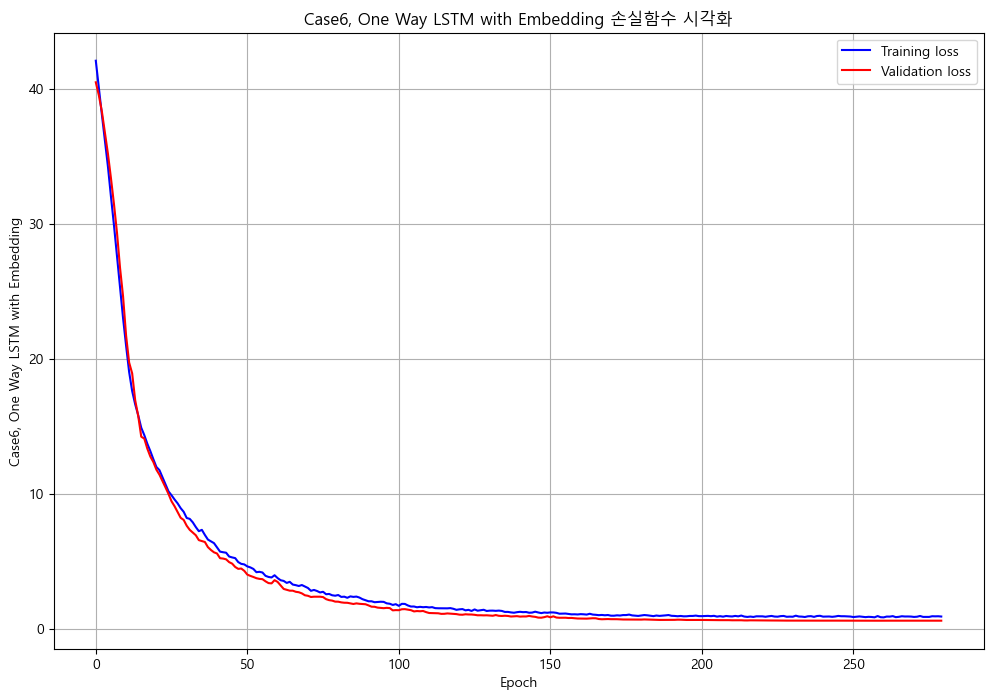

In [210]:
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case6_uni_label = Model(inputs=[numerical_input, categorical_input], outputs=output)
case6_uni_label.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case6_uni_label_history = case6_uni_label.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case6_uni_label_history, "Case6, One Way LSTM with Embedding")

In [211]:
# case6_uni_label.save("./output/case6_lstm_uni_label_mae.h5")
# case6_uni_label.save("./output/case6_lstm_uni_label_mse.h5")
case6_uni_label.save("./output/case6_lstm_uni_label_mse+rmse.h5")

### 양방향 LSTM

Epoch 1/300
16/16 [==============================] - 17s 267ms/step - loss: 73.2010 - root_mean_squared_error: 4.2452 - val_loss: 72.8576 - val_root_mean_squared_error: 4.3786 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 2s 141ms/step - loss: 68.9534 - root_mean_squared_error: 4.0744 - val_loss: 69.6696 - val_root_mean_squared_error: 4.3392 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 2s 139ms/step - loss: 64.5652 - root_mean_squared_error: 3.8801 - val_loss: 66.2442 - val_root_mean_squared_error: 4.2701 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 2s 139ms/step - loss: 60.3225 - root_mean_squared_error: 3.6876 - val_loss: 62.7847 - val_root_mean_squared_error: 4.1842 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 2s 140ms/step - loss: 55.7943 - root_mean_squared_error: 3.4303 - val_loss: 59.2821 - val_root_mean_squared_error: 4.0808 - lr: 5.0000e-04
Epoch 6/300
16/16 [====================

Epoch 44/300
16/16 [==============================] - 2s 139ms/step - loss: 5.9300 - root_mean_squared_error: 0.8800 - val_loss: 6.8309 - val_root_mean_squared_error: 1.3238 - lr: 5.0000e-04
Epoch 45/300
16/16 [==============================] - 2s 139ms/step - loss: 5.6872 - root_mean_squared_error: 0.8361 - val_loss: 6.3033 - val_root_mean_squared_error: 1.1912 - lr: 5.0000e-04
Epoch 46/300
16/16 [==============================] - 2s 140ms/step - loss: 5.4267 - root_mean_squared_error: 0.7820 - val_loss: 6.1733 - val_root_mean_squared_error: 1.2004 - lr: 5.0000e-04
Epoch 47/300
16/16 [==============================] - 2s 138ms/step - loss: 5.3000 - root_mean_squared_error: 0.8093 - val_loss: 6.0221 - val_root_mean_squared_error: 1.2136 - lr: 5.0000e-04
Epoch 48/300
16/16 [==============================] - 2s 140ms/step - loss: 5.1898 - root_mean_squared_error: 0.8449 - val_loss: 5.6808 - val_root_mean_squared_error: 1.1228 - lr: 5.0000e-04
Epoch 49/300
16/16 [=========================

Epoch 86/300
16/16 [==============================] - 3s 158ms/step - loss: 2.5015 - root_mean_squared_error: 0.7453 - val_loss: 2.3275 - val_root_mean_squared_error: 0.6224 - lr: 2.5000e-04
Epoch 87/300
16/16 [==============================] - 2s 153ms/step - loss: 2.4937 - root_mean_squared_error: 0.7466 - val_loss: 2.3818 - val_root_mean_squared_error: 0.6771 - lr: 2.5000e-04
Epoch 88/300
16/16 [==============================] - 3s 158ms/step - loss: 2.4167 - root_mean_squared_error: 0.7154 - val_loss: 2.3539 - val_root_mean_squared_error: 0.6799 - lr: 2.5000e-04
Epoch 89/300
16/16 [==============================] - 2s 156ms/step - loss: 2.3313 - root_mean_squared_error: 0.6736 - val_loss: 2.2696 - val_root_mean_squared_error: 0.6362 - lr: 2.5000e-04
Epoch 90/300
16/16 [==============================] - 2s 154ms/step - loss: 2.3792 - root_mean_squared_error: 0.7151 - val_loss: 2.2629 - val_root_mean_squared_error: 0.6355 - lr: 2.5000e-04
Epoch 91/300
16/16 [=========================

Epoch 128/300
16/16 [==============================] - 3s 158ms/step - loss: 1.7114 - root_mean_squared_error: 0.6439 - val_loss: 1.4252 - val_root_mean_squared_error: 0.3666 - lr: 1.2500e-04
Epoch 129/300
16/16 [==============================] - 2s 156ms/step - loss: 1.7011 - root_mean_squared_error: 0.6391 - val_loss: 1.5109 - val_root_mean_squared_error: 0.4685 - lr: 1.2500e-04
Epoch 130/300
16/16 [==============================] - 2s 151ms/step - loss: 1.7239 - root_mean_squared_error: 0.6614 - val_loss: 1.4951 - val_root_mean_squared_error: 0.4604 - lr: 1.2500e-04
Epoch 131/300
16/16 [==============================] - 2s 150ms/step - loss: 1.7030 - root_mean_squared_error: 0.6495 - val_loss: 1.5863 - val_root_mean_squared_error: 0.5538 - lr: 1.2500e-04
Epoch 132/300
16/16 [==============================] - 2s 149ms/step - loss: 1.7118 - root_mean_squared_error: 0.6554 - val_loss: 1.3885 - val_root_mean_squared_error: 0.3243 - lr: 1.2500e-04
Epoch 133/300
16/16 [===================

Epoch 170/300
16/16 [==============================] - 3s 157ms/step - loss: 1.4256 - root_mean_squared_error: 0.6355 - val_loss: 1.1158 - val_root_mean_squared_error: 0.3120 - lr: 6.2500e-05
Epoch 171/300
16/16 [==============================] - 3s 160ms/step - loss: 1.3617 - root_mean_squared_error: 0.5890 - val_loss: 1.0999 - val_root_mean_squared_error: 0.3004 - lr: 6.2500e-05
Epoch 172/300
16/16 [==============================] - 2s 155ms/step - loss: 1.3354 - root_mean_squared_error: 0.5744 - val_loss: 1.0948 - val_root_mean_squared_error: 0.3018 - lr: 6.2500e-05
Epoch 173/300
16/16 [==============================] - 2s 152ms/step - loss: 1.3286 - root_mean_squared_error: 0.5728 - val_loss: 1.0746 - val_root_mean_squared_error: 0.2776 - lr: 6.2500e-05
Epoch 174/300
16/16 [==============================] - 2s 151ms/step - loss: 1.3370 - root_mean_squared_error: 0.5810 - val_loss: 1.0964 - val_root_mean_squared_error: 0.3189 - lr: 6.2500e-05
Epoch 175/300
16/16 [===================

Epoch 210/300
16/16 [==============================] - 3s 164ms/step - loss: 1.2183 - root_mean_squared_error: 0.5575 - val_loss: 1.0063 - val_root_mean_squared_error: 0.3153 - lr: 7.8125e-06
Epoch 211/300
16/16 [==============================] - 2s 150ms/step - loss: 1.2663 - root_mean_squared_error: 0.5999 - val_loss: 1.0021 - val_root_mean_squared_error: 0.3105 - lr: 7.8125e-06
Epoch 212/300
16/16 [==============================] - 2s 155ms/step - loss: 1.2880 - root_mean_squared_error: 0.6186 - val_loss: 0.9989 - val_root_mean_squared_error: 0.3059 - lr: 7.8125e-06
Epoch 213/300
16/16 [==============================] - 3s 158ms/step - loss: 1.2563 - root_mean_squared_error: 0.5923 - val_loss: 0.9945 - val_root_mean_squared_error: 0.2989 - lr: 7.8125e-06
Epoch 214/300
16/16 [==============================] - 3s 159ms/step - loss: 1.2387 - root_mean_squared_error: 0.5781 - val_loss: 0.9923 - val_root_mean_squared_error: 0.2974 - lr: 7.8125e-06
Epoch 215/300
16/16 [===================

Epoch 252/300
16/16 [==============================] - 3s 163ms/step - loss: 1.2571 - root_mean_squared_error: 0.6119 - val_loss: 0.9611 - val_root_mean_squared_error: 0.2805 - lr: 3.9063e-06
Epoch 253/300
16/16 [==============================] - 3s 157ms/step - loss: 1.2662 - root_mean_squared_error: 0.6197 - val_loss: 0.9582 - val_root_mean_squared_error: 0.2760 - lr: 3.9063e-06
Epoch 254/300
16/16 [==============================] - 3s 168ms/step - loss: 1.2484 - root_mean_squared_error: 0.6053 - val_loss: 0.9601 - val_root_mean_squared_error: 0.2795 - lr: 3.9063e-06
Epoch 255/300
16/16 [==============================] - 3s 170ms/step - loss: 1.2029 - root_mean_squared_error: 0.5668 - val_loss: 0.9608 - val_root_mean_squared_error: 0.2815 - lr: 3.9063e-06
Epoch 256/300
16/16 [==============================] - 3s 159ms/step - loss: 1.1814 - root_mean_squared_error: 0.5478 - val_loss: 0.9602 - val_root_mean_squared_error: 0.2810 - lr: 3.9063e-06
Epoch 257/300
16/16 [===================

Epoch 293/300
16/16 [==============================] - 3s 163ms/step - loss: 1.2433 - root_mean_squared_error: 0.6059 - val_loss: 0.9538 - val_root_mean_squared_error: 0.2785 - lr: 1.0000e-06
Epoch 294/300
16/16 [==============================] - 2s 152ms/step - loss: 1.2064 - root_mean_squared_error: 0.5747 - val_loss: 0.9535 - val_root_mean_squared_error: 0.2784 - lr: 1.0000e-06
Epoch 295/300
16/16 [==============================] - 2s 153ms/step - loss: 1.2136 - root_mean_squared_error: 0.5811 - val_loss: 0.9549 - val_root_mean_squared_error: 0.2810 - lr: 1.0000e-06
Epoch 296/300
16/16 [==============================] - 2s 145ms/step - loss: 1.2329 - root_mean_squared_error: 0.5975 - val_loss: 0.9553 - val_root_mean_squared_error: 0.2818 - lr: 1.0000e-06
Epoch 297/300
16/16 [==============================] - 2s 143ms/step - loss: 1.2219 - root_mean_squared_error: 0.5882 - val_loss: 0.9541 - val_root_mean_squared_error: 0.2799 - lr: 1.0000e-06
Epoch 298/300
16/16 [===================

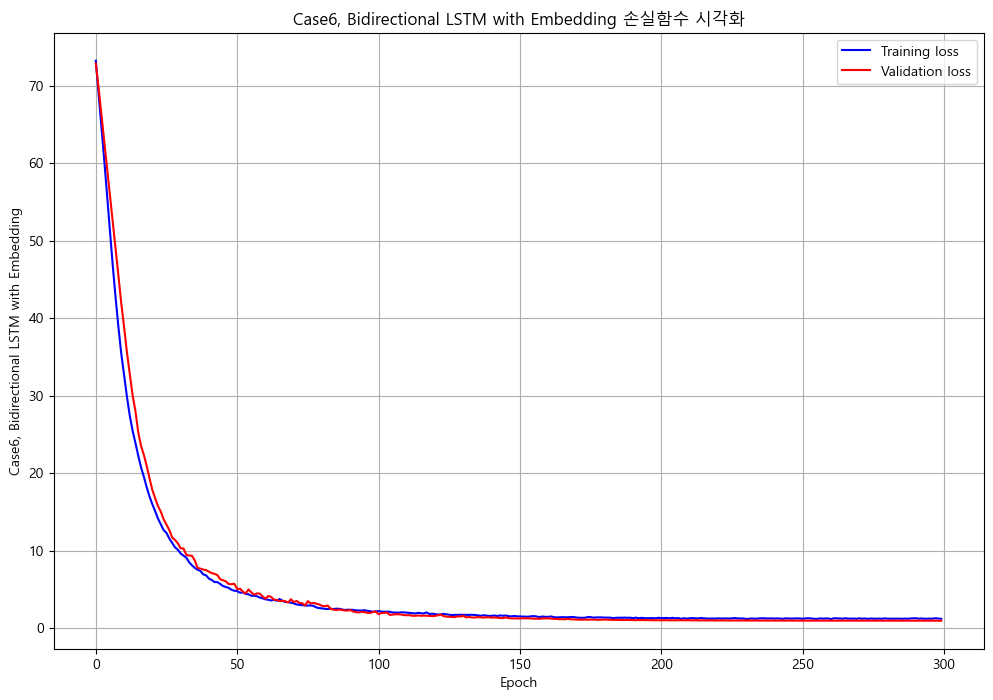

In [212]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers
from tensorflow.keras import metrics

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case6_bi_label = Model(inputs=[numerical_input, categorical_input], outputs=output)

case6_bi_label.compile(optimizer=optimizer
                       , loss="mse"
                       , metrics=[metrics.RootMeanSquaredError()]
                      )

# 모델 학습
case6_bi_label_history = case6_bi_label.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case6_bi_label_history, "Case6, Bidirectional LSTM with Embedding")

In [213]:
# case6_bi_label.save("./output/case6_lstm_bi_label_mae.h5")
# case6_bi_label.save("./output/case6_lstm_bi_label_mse.h5")
case6_bi_label.save("./output/case6_lstm_bi_label_mse+rmse.h5")

# 중간점검

In [214]:
# 검증데이터 구성
X_compare3_std = case5_dts[376 : 388, :]
X_compare3_std_label = case5_label[376 : 388]
X_compare3_std = np.reshape(X_compare3_std, (1, 12, 6))
X_compare3_std_label = np.reshape(X_compare3_std_label, (1, 12))

Y_compare3_std = case5_dts[388 : 400, -1]
Y_compare3_std_ = Y_compare3_std * case5_std[-1] + case5_mean[-1]

# Case5_uni
Y_HAT_Case5_uni = case5_uni_label.predict([X_compare3_std, X_compare3_std_label])
Y_HAT_Case5_uni_ = Y_HAT_Case5_uni * case5_std[-1] + case5_mean[-1]

# Case3_bi
Y_HAT_Case5_bi = case5_bi_label.predict([X_compare3_std, X_compare3_std_label])
Y_HAT_Case5_bi_ = Y_HAT_Case5_bi * case5_std[-1] + case5_mean[-1]

1/1 [==============================] - 2s 2s/step


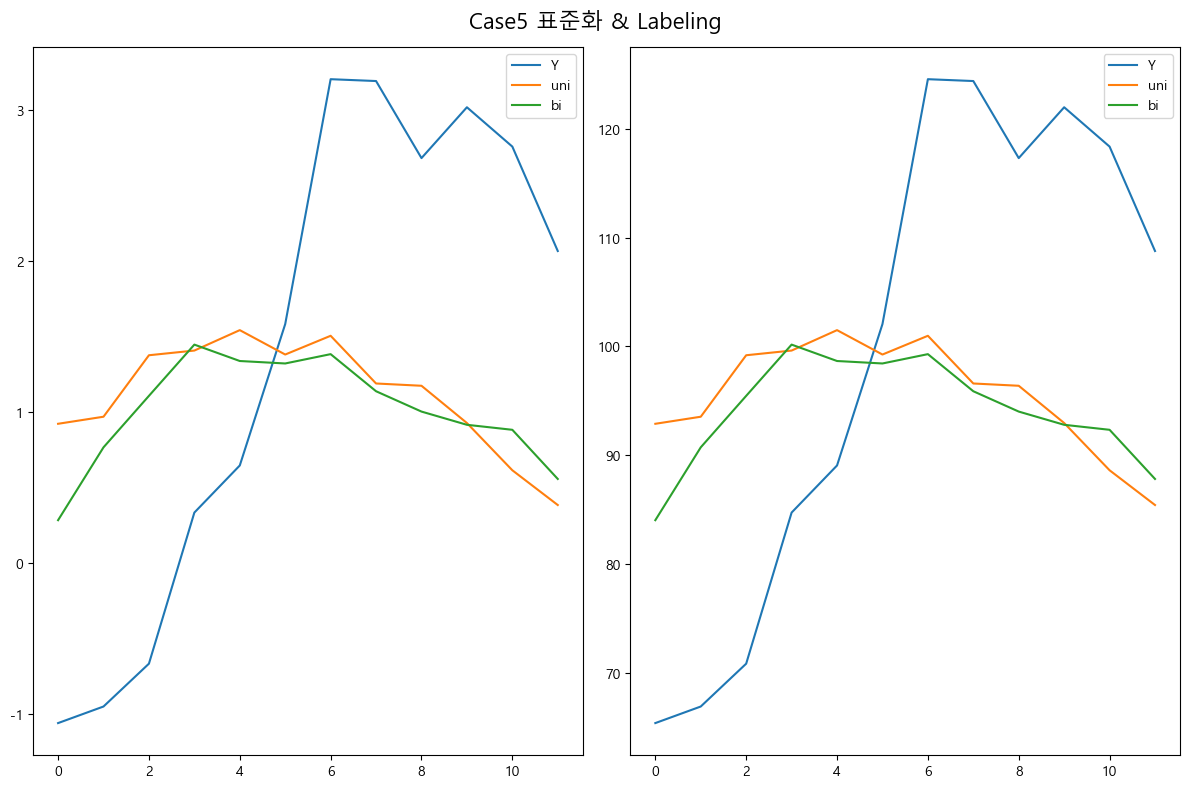

In [215]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare3_std, label="Y")
ax[0].plot(Y_HAT_Case5_uni[0], label="uni")
ax[0].plot(Y_HAT_Case5_bi[0], label="bi")

ax[0].legend()

ax[1].plot(Y_compare3_std_, label="Y")
ax[1].plot(Y_HAT_Case5_uni_[0], label="uni")
ax[1].plot(Y_HAT_Case5_bi_[0], label="bi")

ax[1].legend()

plt.suptitle("Case5 표준화 & Labeling", fontsize=16)

plt.tight_layout()

plt.show()

---

In [216]:
# 검증데이터 구성
X_compare3_log = case6_dts[376 : 388, :]
X_compare3_log_label = case6_label[376 : 388]
X_compare3_log = np.reshape(X_compare3_log, (1, 12, 6))
X_compare3_log_label = np.reshape(X_compare3_log_label, (1, 12))

Y_compare3_log = case6_dts[388 : 400, -1]
Y_compare3_log_ = np.sign(Y_compare3_log) * (np.expm1(np.abs(Y_compare3_log)))

# Case2_uni
Y_HAT_Case6_uni = case6_uni_label.predict([X_compare3_log, X_compare3_log_label])
Y_HAT_Case6_uni_ = np.sign(Y_HAT_Case6_uni) * (np.expm1(np.abs(Y_HAT_Case6_uni)))

# Case2_bi
Y_HAT_Case6_bi = case6_bi_label.predict([X_compare3_log, X_compare3_log_label])
Y_HAT_Case6_bi_ = np.sign(Y_HAT_Case6_bi) * (np.expm1(np.abs(Y_HAT_Case6_bi)))

1/1 [==============================] - 2s 2s/step


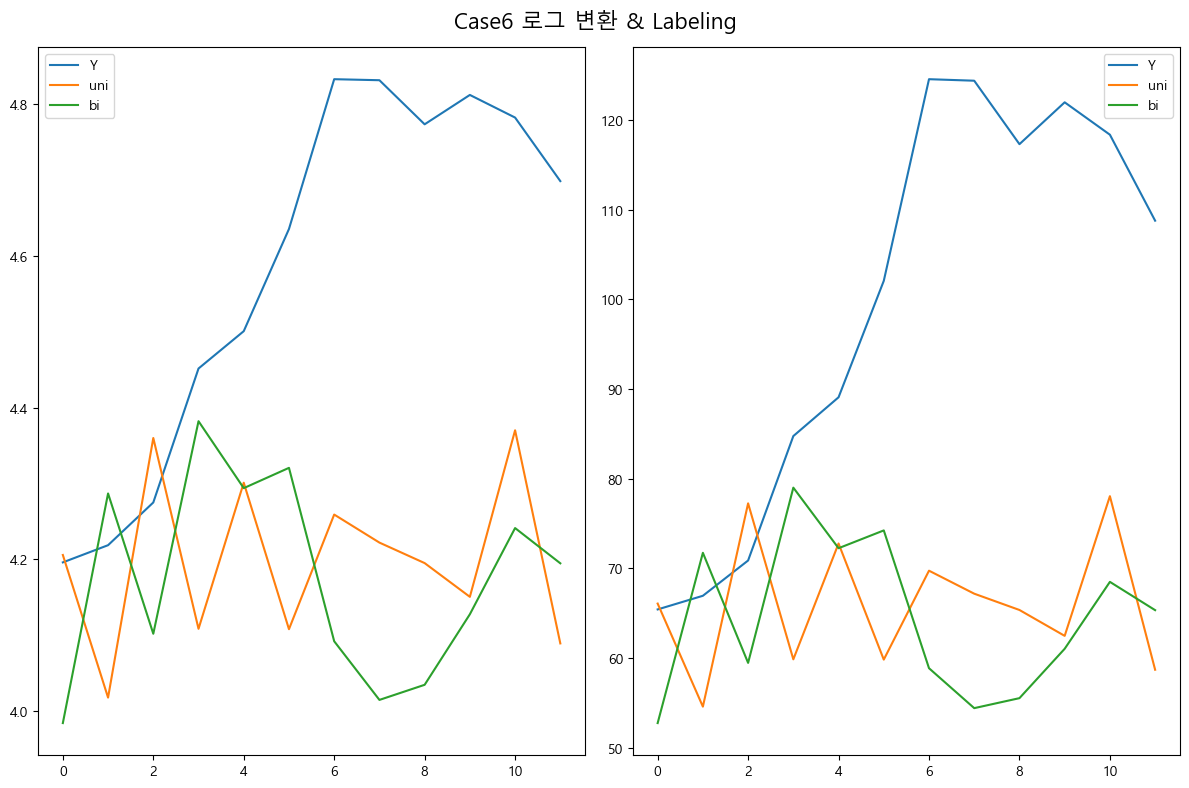

In [217]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare3_log, label="Y")
ax[0].plot(Y_HAT_Case6_uni[0], label="uni")
ax[0].plot(Y_HAT_Case6_bi[0], label="bi")

ax[0].legend()

ax[1].plot(Y_compare3_log_, label="Y")
ax[1].plot(Y_HAT_Case6_uni_[0], label="uni")
ax[1].plot(Y_HAT_Case6_bi_[0], label="bi")

ax[1].legend()

plt.suptitle("Case6 로그 변환 & Labeling", fontsize=16)

plt.tight_layout()

plt.show()